## Reading in packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
#import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc

# Tensorflow related
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.compat.v2.feature_column as fc

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v9

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix
#print('hej')

2.2.0
C:\Users\PC\AppData\Local\Temp\tmp_c6128f5\tensorboard_logs


## Extracting data

In [2]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec (1).csv
1: aggregateTAQ_May2020_30sec (1).csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


# reading in the market data (done automatically atm)

In [3]:
file

'8'

In [4]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385   91.500   91.755   91.485   91.740         0.42         0.93   
         386   91.740   91.740   91.740   91.740         0.50         0.50   
         387   91.580   91.830   91.580   91.715         0.18         0.68   
         388   91.595   91.880   91.595   91.750         0.21         0.78   
         389   46.005   46.005   45.815   45.815        92.01        92.01   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.39          0.50           5.0           5.0   
         386        0.50          0.50           5.0           5.0   
         387        0.18          0.45           5.0           5.0   
         388        0.21          0.52           5.0           5.0   
         389       91.63         91.63           0.0           0.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          5.0            5.0           1.0           5.0   
         386          5.0            5.0           5.0           5.0   
         387          5.0            5.0           1.0           5.0   
         388          5.0            5.0           1.0           5.0   
         389          0.0            0.0           5.0           5.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            5.0   XNTK         NaN  
         386          5.0            5.0   XNTK         NaN  
         387          1.0            5.0   XNTK         NaN  
         388          1.0            5.0   XNTK         NaN  
         389          1.0            1.0   XNTK         NaN  

[546000 rows x 18 columns]

In [5]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385   91.500   91.755   91.485   91.740         0.42         0.93   
         386   91.740   91.740   91.740   91.740         0.50         0.50   
         387   91.580   91.830   91.580   91.715         0.18         0.68   
         388   91.595   91.880   91.595   91.750         0.21         0.78   
         389   46.005   46.005   45.815   45.815        92.01        92.01   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.39          0.50           5.0           5.0   
         386        0.50          0.50           5.0           5.0   
         387        0.18          0.45           5.0           5.0   
         388        0.21          0.52           5.0           5.0   
         389       91.63         91.63           0.0           0.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          5.0            5.0           1.0           5.0   
         386          5.0            5.0           5.0           5.0   
         387          5.0            5.0           1.0           5.0   
         388          5.0            5.0           1.0           5.0   
         389          0.0            0.0           5.0           5.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            5.0   XNTK         NaN  
         386          5.0            5.0   XNTK         NaN  
         387          1.0            5.0   XNTK         NaN  
         388          1.0            5.0   XNTK         NaN  
         389          1.0            1.0   XNTK         NaN  

[546000 rows x 18 columns]

In [6]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

### Dropping ETFS and market indices

In [7]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY', 'XNTK'], dtype=object)

In [8]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [9]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY'], dtype=object)

In [10]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [11]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

In [12]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            4.0   AAPL          Technology  
         1            1.0            1.0   AAPL          Technology  
         2            1.0            1.0   AAPL          Technology  
         3            1.0            1.0   AAPL          Technology  
         4            1.0            1.0   AAPL          Technology  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    WMT  Consumer Defensive  
         386          1.0            2.0    WMT  Consumer Defensive  
         387          1.0            2.0    WMT  Consumer Defensive  
         388          1.0            4.0    WMT  Consumer Defensive  
         389          1.0            1.0    WMT  Consumer Defensive  

[429000 rows x 18 columns]

In [13]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
#                                                     'stok',
#                                                     'stod',
#                                                     'sstod',
# #                                                     'wilr',
#                                                     'roc',
#                                                     'rsi',
#                                                     'atr',
#                                                     'cci',
#                                                     'dpo',
#                                                     'sma',
#                                                     'ema',
#                                                     'macd',
#                                                       'macd_diff',
#                                                       'macd_signal',
#                                                     'dis5',
#                                                     'dis10',
                                                      'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 5
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_v9(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,
                                                 ticker_dummies=False)

0
            days  timestamps ticker
0     20200501.0         1.0   AAPL
1     20200501.0         2.0   AAPL
2     20200501.0         3.0   AAPL
3     20200501.0         4.0   AAPL
4     20200501.0         5.0   AAPL
...          ...         ...    ...
7793  20200529.0       384.0   AAPL
7794  20200529.0       385.0   AAPL
7795  20200529.0       386.0   AAPL
7796  20200529.0       387.0   AAPL
7797  20200529.0       388.0   AAPL

[7798 rows x 3 columns]
(7798, 71) (7798, 3) (7798,)
         days  timestamps ticker
0  20200501.0         1.0   AAPL
1  20200501.0         2.0   AAPL
2  20200501.0         3.0   AAPL
3  20200501.0         4.0   AAPL
4  20200501.0         5.0   AAPL
5  20200501.0         6.0   AAPL
6  20200501.0         7.0   AAPL
7  20200501.0         8.0   AAPL
8  20200501.0         9.0   AAPL
9  20200501.0        10.0   AAPL
         days  timestamps ticker
0  20200501.0         1.0   AAPL
1  20200501.0         2.0   AAPL
2  20200501.0         3.0   AAPL
3  20200501.0    

In [14]:
(features[features.ticker=='AAPL'].close_lag0.values[1:]/features[features.ticker=='AAPL'].close_lag0.values[0:-1])-1

array([-0.00152239,  0.0017846 ,  0.00423736, ..., -0.00245727,
       -0.00236918,         nan])

In [15]:
features.close_lag0.iloc[0:]

20200501.0  1.0      289.020
            2.0      288.580
            3.0      289.095
            4.0      290.320
            5.0      290.085
                      ...   
20200529.0  386.0    123.995
            387.0    124.335
            388.0    124.075
            389.0    123.855
NaN         NaN          NaN
Name: close_lag0, Length: 429000, dtype: float64

In [16]:
features.columns.values

array(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0',
       'spread_open_lag0', 'spread_high_lag0', 'spread_low_lag0',
       'spread_close_lag0', 'bidsize_open_lag0', 'bidsize_high_lag0',
       'bidsize_low_lag0', 'bidsize_close_lag0', 'ofrsize_open_lag0',
       'ofrsize_high_lag0', 'ofrsize_low_lag0', 'ofrsize_close_lag0',
       'relReturns_DIA_lag0', 'relReturns_IDU_lag0',
       'relReturns_IYC_lag0', 'relReturns_IYE_lag0',
       'relReturns_IYG_lag0', 'relReturns_IYH_lag0',
       'relReturns_IYJ_lag0', 'relReturns_IYK_lag0',
       'relReturns_IYM_lag0', 'relReturns_IYR_lag0',
       'relReturns_IYW_lag0', 'relReturns_IYZ_lag0',
       'relReturns_QQQ_lag0', 'relReturns_SPY_lag0', 'open_lag1',
       'high_lag1', 'low_lag1', 'close_lag1', 'spread_open_lag1',
       'spread_high_lag1', 'spread_low_lag1', 'spread_close_lag1',
       'bidsize_open_lag1', 'bidsize_high_lag1', 'bidsize_low_lag1',
       'bidsize_close_lag1', 'ofrsize_open_lag1', 'ofrsize_high_lag1',
       '

In [17]:
features.iloc[0:10,0:20]

open_lag0  high_lag0  low_lag0  close_lag0  spread_open_lag0  \
20200501.0 1.0       0.240      0.330    -0.655     289.020              0.24   
           2.0       0.455      1.125    -0.300     288.580              0.07   
           3.0      -0.610      0.220    -0.815     289.095              0.49   
           4.0      -1.220      0.115    -1.380     290.320              0.16   
           5.0       0.235      0.355    -0.565     290.085              0.10   
           6.0      -1.120      0.105    -1.125     291.110              0.24   
           7.0      -0.425      0.190    -0.935     291.545              0.08   
           8.0      -0.565      0.055    -0.840     292.115              0.08   
           9.0      -0.485      0.380    -0.990     292.580              0.11   
           10.0     -0.035      0.890    -0.415     292.630              0.15   

                 spread_high_lag0  spread_low_lag0  spread_close_lag0  \
20200501.0 1.0               0.45             0.01               0.10   
           2.0               0.49             0.01               0.30   
           3.0               0.49             0.01               0.17   
           4.0               0.33             0.01               0.10   
           5.0               0.42             0.01               0.05   
           6.0               0.30             0.01               0.10   
           7.0               0.34             0.01               0.09   
           8.0               0.35             0.01               0.15   
           9.0               0.31             0.01               0.12   
           10.0              0.45             0.01               0.14   

                 bidsize_open_lag0  bidsize_high_lag0  bidsize_low_lag0  \
20200501.0 1.0                 9.0               20.0               1.0   
           2.0                 1.0               50.0               1.0   
           3.0                 1.0               25.0               1.0   
           4.0                13.0               71.0               1.0   
           5.0                 2.0               86.0               1.0   
           6.0                 1.0               10.0               1.0   
           7.0                 1.0               40.0               1.0   
           8.0                 1.0                6.0               1.0   
           9.0                 1.0               20.0               1.0   
           10.0                2.0               51.0               1.0   

                 bidsize_close_lag0  ofrsize_open_lag0  ofrsize_high_lag0  \
20200501.0 1.0                  1.0                4.0               56.0   
           2.0                  1.0                1.0               13.0   
           3.0                 16.0                1.0                8.0   
           4.0                  1.0                1.0              236.0   
           5.0                  1.0                1.0               18.0   
           6.0                  4.0                1.0               97.0   
           7.0                  1.0                1.0               20.0   
           8.0                  1.0                1.0              116.0   
           9.0                  2.0                1.0              192.0   
           10.0                 7.0                1.0              195.0   

                 ofrsize_low_lag0  ofrsize_close_lag0  relReturns_DIA_lag0  \
20200501.0 1.0                1.0                 1.0            -0.001310   
           2.0                1.0                 1.0            -0.003108   
           3.0                1.0                 1.0             0.001451   
           4.0                1.0                 1.0             0.004175   
           5.0                1.0                 1.0             0.001252   
           6.0                1.0                 1.0             0.003262   
           7.0                1.0                 1.0             0.002725   
           8.0         

In [18]:
data.loc[20200501,1]

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


open      high       low     close  spread_open  spread_high  \
20200501 1   289.260   289.350   288.365   289.020         0.24         0.45   
         1    81.010    82.070    81.010    81.760         0.24         1.06   
         1    91.190    91.380    90.900    91.220         0.18         0.58   
         1    82.475    82.475    82.270    82.370         0.13         0.54   
         1   233.205   234.225   233.160   233.540         2.39         3.99   
         1   219.725   222.465   219.725   222.465         7.29         7.61   
         1   142.260   143.805   142.260   142.890         0.26         1.42   
         1   196.675   197.285   196.465   196.920         0.25         0.41   
         1    23.415    23.435    23.335    23.345         0.01         0.04   
         1    38.985    38.985    38.895    38.985         0.03         0.08   
         1    22.985    23.145    22.985    23.145         0.01         0.03   
         1   156.405   156.540   156.405   156.540         1.25         1.25   
         1    39.265    39.335    39.190    39.255         0.45         0.45   
         1   301.300   301.785   301.300   301.760         0.40         0.44   
         1   642.765   642.830   633.925   638.615        14.47        15.20   
         1    76.310    76.380    76.145    76.180         0.10         0.23   
         1   106.110   106.175   105.695   105.765         0.18         0.24   
         1   188.890   190.025   188.230   189.350         1.22         4.72   
         1    30.085    30.155    30.035    30.085         0.05         0.17   
         1    36.290    36.415    36.270    36.375         0.08         0.27   
         1   202.605   202.870   201.840   202.680         0.09         0.38   
         1    63.050    63.525    63.050    63.230         3.84         3.84   
         1  1332.765  1333.990  1331.495  1332.650         2.47         4.59   
         1    58.795    58.845    58.680    58.820         0.11         0.19   
         1   148.905   149.275   148.745   148.905         0.55         1.07   
         1    45.445    45.520    45.370    45.470         0.05         0.08   
         1    10.330    10.330    10.245    10.290         0.10         0.10   
         1   183.415   183.420   182.790   183.250         0.47         1.59   
         1   386.460   388.480   386.375   387.765         0.68         4.53   
         1   269.440   270.265   268.860   269.125         0.74         2.65   
         1   184.170   184.580   183.790   184.390         0.22         1.48   
         1   175.955   176.525   175.895   176.515         0.07         0.28   
         1    85.490    85.490    85.150    85.270         0.10         0.44   
         1   284.610   286.455   284.360   286.320         0.28         0.91   
         1    84.210    84.210    84.210    84.210         0.18         0.18   
         1     6.715     6.745     6.715     6.735         0.01         0.02   
         1   131.265   131.300   131.130   131.270         0.45         0.45   
         1    37.855    37.860    37.750    37.785         0.01         0.09   
         1    87.150    87.240    87.085    87.100         0.30         0.35   
         1   184.725   185.475   179.820   179.820         8.81         9.15   
         1    35.020    35.035    34.920    34.920         0.90         0.93   
         1   120.230   120.900   120.215   120.815         0.22         0.47   
         1    63.095    63.410    63.065    63.290         0.19         0.57   
         1   527.200   527.200   527.200   527.200        19.54        19.54   
         1    48.470    48.475    48.350    48.475         0.94         0.95   
         1    55.950    55.995    55.750    55.845         0.10         0.44   
         1   120.980   121.535   120.980   121.405         1.76         1.76   
         1    30.700    30.785    30.670    30.685         0.02         0.07   
         1   121.655   121.725   121.655   121.725         0.41         0.41   
         1   762

In [19]:
features

open_lag0  high_lag0  low_lag0  close_lag0  \
20200501.0 1.0        0.240      0.330    -0.655     289.020   
           2.0        0.455      1.125    -0.300     288.580   
           3.0       -0.610      0.220    -0.815     289.095   
           4.0       -1.220      0.115    -1.380     290.320   
           5.0        0.235      0.355    -0.565     290.085   
...                     ...        ...       ...         ...   
20200529.0 386.0      0.090      0.090    -0.075     123.995   
           387.0     -0.340      0.020    -0.350     124.335   
           388.0      0.260      0.280    -0.015     124.075   
           389.0      0.220      0.370    -1.045     123.855   
NaN        NaN          NaN        NaN       NaN         NaN   

                  spread_open_lag0  spread_high_lag0  spread_low_lag0  \
20200501.0 1.0                0.24              0.45             0.01   
           2.0                0.07              0.49             0.01   
           3.0                0.49              0.49             0.01   
           4.0                0.16              0.33             0.01   
           5.0                0.10              0.42             0.01   
...                            ...               ...              ...   
20200529.0 386.0              0.01              0.06             0.01   
           387.0              0.01              0.07             0.01   
           388.0              0.05              0.12             0.01   
           389.0              0.01              2.43             0.01   
NaN        NaN                 NaN               NaN              NaN   

                  spread_close_lag0  bidsize_open_lag0  bidsize_high_lag0  \
20200501.0 1.0                 0.10                9.0               20.0   
           2.0                 0.30                1.0               50.0   
           3.0                 0.17                1.0               25.0   
           4.0                 0.10               13.0               71.0   
           5.0                 0.05                2.0               86.0   
...                             ...                ...                ...   
20200529.0 386.0               0.01                1.0                8.0   
           387.0               0.05                4.0               16.0   
           388.0               0.01                3.0                6.0   
           389.0               0.21                1.0               20.0   
NaN        NaN                  NaN                NaN                NaN   

                  ...  d_sector_Communication Services  \
20200501.0 1.0    ...                                0   
           2.0    ...                                0   
           3.0    ...                                0   
           4.0    ...                                0   
           5.0    ...                                0   
...               ...                              ...   
20200529.0 386.0  ...                                0   
           387.0  ...                                0   
           388.0  ...                                0   
           389.0  ...                                0   
NaN        NaN    ...                                0   

                  d_sector_Consumer Cyclical  d_sector_Consumer Defensive  \
20200501.0 1.0                             0                            0   
           2.0                             0                            0   
           3.0                             0                            0   
           4.0                             0                            0   
           5.0                             0                            0   
...                                      ...                          ...   
20200529.0 386.0                           0                            1   
           387.0                           0                            1   
           388.0                           0             

In [20]:
indices

,days,timestamps,ticker
0,20200501.0,1.0,AAPL
1,20200501.0,2.0,AAPL
2,20200501.0,3.0,AAPL
3,20200501.0,4.0,AAPL
4,20200501.0,5.0,AAPL
...,...,...,...
428885,20200529.0,384.0,WMT
428886,20200529.0,385.0,WMT
428887,20200529.0,386.0,WMT
428888,20200529.0,387.0,WMT


In [21]:
X

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_sector_Consumer Cyclical,d_sector_Consumer Defensive,d_sector_Energy,d_sector_Financial Services,d_sector_Healthcare,d_sector_Industrials,d_sector_Real Estate,d_sector_Technology,d_sector_Utilities,ticker
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,0,0,0,0,0,0,0,1,0,AAPL
1,0.455,1.125,-0.300,288.580,0.07,0.49,0.01,0.30,1.0,50.0,...,0,0,0,0,0,0,0,1,0,AAPL
2,-0.610,0.220,-0.815,289.095,0.49,0.49,0.01,0.17,1.0,25.0,...,0,0,0,0,0,0,0,1,0,AAPL
3,-1.220,0.115,-1.380,290.320,0.16,0.33,0.01,0.10,13.0,71.0,...,0,0,0,0,0,0,0,1,0,AAPL
4,0.235,0.355,-0.565,290.085,0.10,0.42,0.01,0.05,2.0,86.0,...,0,0,0,0,0,0,0,1,0,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428885,-0.110,0.010,-0.175,123.950,0.02,0.07,0.01,0.02,3.0,6.0,...,0,1,0,0,0,0,0,0,0,WMT
428886,-0.150,0.010,-0.190,124.100,0.02,0.07,0.01,0.04,1.0,11.0,...,0,1,0,0,0,0,0,0,0,WMT
428887,0.090,0.090,-0.075,123.995,0.01,0.06,0.01,0.01,1.0,8.0,...,0,1,0,0,0,0,0,0,0,WMT
428888,-0.340,0.020,-0.350,124.335,0.01,0.07,0.01,0.05,4.0,16.0,...,0,1,0,0,0,0,0,0,0,WMT


## Splitting the data

In [168]:
data.shape,X.shape

((429000, 18), (428780, 132))

In [22]:
indices

,days,timestamps,ticker
0,20200501.0,1.0,AAPL
1,20200501.0,2.0,AAPL
2,20200501.0,3.0,AAPL
3,20200501.0,4.0,AAPL
4,20200501.0,5.0,AAPL
...,...,...,...
428885,20200529.0,384.0,WMT
428886,20200529.0,385.0,WMT
428887,20200529.0,386.0,WMT
428888,20200529.0,387.0,WMT


In [170]:
data['Ticker'].reset_index()

,level_0,level_1,Ticker
0,20200501,0,AAPL
1,20200501,1,AAPL
2,20200501,2,AAPL
3,20200501,3,AAPL
4,20200501,4,AAPL
...,...,...,...
428995,20200529,385,WMT
428996,20200529,386,WMT
428997,20200529,387,WMT
428998,20200529,388,WMT


In [22]:
indices

,days,timestamps,ticker
0,20200501,1.0,AAPL
1,20200501,2.0,AAPL
2,20200501,3.0,AAPL
3,20200501,4.0,AAPL
4,20200501,5.0,AAPL
...,...,...,...
428885,20200529,384.0,WMT
428886,20200529,385.0,WMT
428887,20200529,386.0,WMT
428888,20200529,387.0,WMT


In [33]:
X

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_sector_Consumer Cyclical,d_sector_Consumer Defensive,d_sector_Energy,d_sector_Financial Services,d_sector_Healthcare,d_sector_Industrials,d_sector_Real Estate,d_sector_Technology,d_sector_Utilities,ticker
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,0,0,0,0,0,0,0,1,0,AAPL
1,0.455,1.125,-0.300,288.580,0.07,0.49,0.01,0.30,1.0,50.0,...,0,0,0,0,0,0,0,1,0,AAPL
2,-0.610,0.220,-0.815,289.095,0.49,0.49,0.01,0.17,1.0,25.0,...,0,0,0,0,0,0,0,1,0,AAPL
3,-1.220,0.115,-1.380,290.320,0.16,0.33,0.01,0.10,13.0,71.0,...,0,0,0,0,0,0,0,1,0,AAPL
4,0.235,0.355,-0.565,290.085,0.10,0.42,0.01,0.05,2.0,86.0,...,0,0,0,0,0,0,0,1,0,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428885,-0.110,0.010,-0.175,123.950,0.02,0.07,0.01,0.02,3.0,6.0,...,0,1,0,0,0,0,0,0,0,WMT
428886,-0.150,0.010,-0.190,124.100,0.02,0.07,0.01,0.04,1.0,11.0,...,0,1,0,0,0,0,0,0,0,WMT
428887,0.090,0.090,-0.075,123.995,0.01,0.06,0.01,0.01,1.0,8.0,...,0,1,0,0,0,0,0,0,0,WMT
428888,-0.340,0.020,-0.350,124.335,0.01,0.07,0.01,0.05,4.0,16.0,...,0,1,0,0,0,0,0,0,0,WMT


In [36]:
features

open_lag0  high_lag0  low_lag0  close_lag0  spread_open_lag0  \
20200501 1.0        0.240      0.330    -0.655     289.020              0.24   
         2.0        0.455      1.125    -0.300     288.580              0.07   
         3.0       -0.610      0.220    -0.815     289.095              0.49   
         4.0       -1.220      0.115    -1.380     290.320              0.16   
         5.0        0.235      0.355    -0.565     290.085              0.10   
...                   ...        ...       ...         ...               ...   
20200529 386.0      0.090      0.090    -0.075     123.995              0.01   
         387.0     -0.340      0.020    -0.350     124.335              0.01   
         388.0      0.260      0.280    -0.015     124.075              0.05   
         389.0      0.220      0.370    -1.045     123.855              0.01   
         NaN          NaN        NaN       NaN         NaN               NaN   

                spread_high_lag0  spread_low_lag0  spread_close_lag0  \
20200501 1.0                0.45             0.01               0.10   
         2.0                0.49             0.01               0.30   
         3.0                0.49             0.01               0.17   
         4.0                0.33             0.01               0.10   
         5.0                0.42             0.01               0.05   
...                          ...              ...                ...   
20200529 386.0              0.06             0.01               0.01   
         387.0              0.07             0.01               0.05   
         388.0              0.12             0.01               0.01   
         389.0              2.43             0.01               0.21   
         NaN                 NaN              NaN                NaN   

                bidsize_open_lag0  bidsize_high_lag0  ...  \
20200501 1.0                  9.0               20.0  ...   
         2.0                  1.0               50.0  ...   
         3.0                  1.0               25.0  ...   
         4.0                 13.0               71.0  ...   
         5.0                  2.0               86.0  ...   
...                           ...                ...  ...   
20200529 386.0                1.0                8.0  ...   
         387.0                4.0               16.0  ...   
         388.0                3.0                6.0  ...   
         389.0                1.0               20.0  ...   
         NaN                  NaN                NaN  ...   

                d_sector_Communication Services  d_sector_Consumer Cyclical  \
20200501 1.0                                  0                           0   
         2.0                                  0                           0   
         3.0                                  0                           0   
         4.0                                  0                           0   
         5.0                                  0                           0   
...                                         ...                         ...   
20200529 386.0                                0                           0   
         387.0                                0                           0   
         388.0                                0                           0   
         389.0                                0                           0   
         NaN                                  0                           0   

                d_sector_Consumer Defensive  d_sector_Energy  \
20200501 1.0                              0                0   
         2.0                              0                0   
         3.0                              0                0   
         4.0                              0                0   
         5.0                              0                0   
...                                     ...              ...   
20200529 386.0                            1                0

In [35]:
indices.sort_values(['days','timestamps','ticker'])

,days,timestamps,ticker
389,20200501,0.0,AAPL
8187,20200501,0.0,ABBV
15985,20200501,0.0,ABT
23783,20200501,0.0,AEP
31581,20200501,0.0,AMT
...,...,...,...
397697,20200529,388.0,TSM
405495,20200529,388.0,UNP
413293,20200529,388.0,UPS
421091,20200529,388.0,V


In [34]:
data.loc[20200501,1]

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


open      high       low     close  spread_open  spread_high  \
20200501 1   289.260   289.350   288.365   289.020         0.24         0.45   
         1    81.010    82.070    81.010    81.760         0.24         1.06   
         1    91.190    91.380    90.900    91.220         0.18         0.58   
         1    82.475    82.475    82.270    82.370         0.13         0.54   
         1   233.205   234.225   233.160   233.540         2.39         3.99   
         1   219.725   222.465   219.725   222.465         7.29         7.61   
         1   142.260   143.805   142.260   142.890         0.26         1.42   
         1   196.675   197.285   196.465   196.920         0.25         0.41   
         1    23.415    23.435    23.335    23.345         0.01         0.04   
         1    38.985    38.985    38.895    38.985         0.03         0.08   
         1    22.985    23.145    22.985    23.145         0.01         0.03   
         1   156.405   156.540   156.405   156.540         1.25         1.25   
         1    39.265    39.335    39.190    39.255         0.45         0.45   
         1   301.300   301.785   301.300   301.760         0.40         0.44   
         1   642.765   642.830   633.925   638.615        14.47        15.20   
         1    76.310    76.380    76.145    76.180         0.10         0.23   
         1   106.110   106.175   105.695   105.765         0.18         0.24   
         1   188.890   190.025   188.230   189.350         1.22         4.72   
         1    30.085    30.155    30.035    30.085         0.05         0.17   
         1    36.290    36.415    36.270    36.375         0.08         0.27   
         1   202.605   202.870   201.840   202.680         0.09         0.38   
         1    63.050    63.525    63.050    63.230         3.84         3.84   
         1  1332.765  1333.990  1331.495  1332.650         2.47         4.59   
         1    58.795    58.845    58.680    58.820         0.11         0.19   
         1   148.905   149.275   148.745   148.905         0.55         1.07   
         1    45.445    45.520    45.370    45.470         0.05         0.08   
         1    10.330    10.330    10.245    10.290         0.10         0.10   
         1   183.415   183.420   182.790   183.250         0.47         1.59   
         1   386.460   388.480   386.375   387.765         0.68         4.53   
         1   269.440   270.265   268.860   269.125         0.74         2.65   
         1   184.170   184.580   183.790   184.390         0.22         1.48   
         1   175.955   176.525   175.895   176.515         0.07         0.28   
         1    85.490    85.490    85.150    85.270         0.10         0.44   
         1   284.610   286.455   284.360   286.320         0.28         0.91   
         1    84.210    84.210    84.210    84.210         0.18         0.18   
         1     6.715     6.745     6.715     6.735         0.01         0.02   
         1   131.265   131.300   131.130   131.270         0.45         0.45   
         1    37.855    37.860    37.750    37.785         0.01         0.09   
         1    87.150    87.240    87.085    87.100         0.30         0.35   
         1   184.725   185.475   179.820   179.820         8.81         9.15   
         1    35.020    35.035    34.920    34.920         0.90         0.93   
         1   120.230   120.900   120.215   120.815         0.22         0.47   
         1    63.095    63.410    63.065    63.290         0.19         0.57   
         1   527.200   527.200   527.200   527.200        19.54        19.54   
         1    48.470    48.475    48.350    48.475         0.94         0.95   
         1    55.950    55.995    55.750    55.845         0.10         0.44   
         1   120.980   121.535   120.980   121.405         1.76         1.76   
         1    30.700    30.785    30.670    30.685         0.02         0.07   
         1   121.655   121.725   121.655   121.725         0.41         0.41   
         1   762

In [30]:
X.loc[tempIndices[(tempIndices.days == 20200526)&(tempIndices.timestamps==0)].index]

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_ticker_SO,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT
6629,-1.285,0.500,-1.375,317.300,0.31,0.86,0.01,0.16,5.0,15.0,...,0,0,0,0,0,0,0,0,0,0
14427,0.275,0.365,-0.180,90.705,0.94,1.85,0.02,0.23,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
22225,-0.260,0.435,-0.510,89.360,1.56,2.46,0.03,0.26,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
30023,-0.270,0.140,-0.310,80.900,0.98,0.98,0.04,0.08,2.0,7.0,...,0,0,0,0,0,0,0,0,0,0
37821,-1.170,1.160,-2.025,245.730,6.14,7.47,0.35,1.58,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0
45619,1.375,1.375,-1.475,238.950,1.67,4.43,0.53,0.76,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
53417,0.610,1.030,-0.040,148.585,0.79,0.87,0.01,0.15,1.0,50.0,...,0,0,0,0,0,0,0,0,0,0
61215,1.110,1.245,-0.125,201.655,0.43,0.43,0.01,0.11,2.0,10.0,...,0,0,0,0,0,0,0,0,0,0
69013,0.120,0.205,-0.175,25.945,0.35,0.35,0.01,0.01,1.0,170.0,...,0,0,0,0,0,0,0,0,0,0
76811,0.070,0.105,-0.450,46.430,0.06,1.08,0.01,0.02,4.0,16.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
data.loc[20200501,1]

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


open      high       low     close  spread_open  spread_high  \
20200501 1   289.260   289.350   288.365   289.020         0.24         0.45   
         1    81.010    82.070    81.010    81.760         0.24         1.06   
         1    91.190    91.380    90.900    91.220         0.18         0.58   
         1    82.475    82.475    82.270    82.370         0.13         0.54   
         1   233.205   234.225   233.160   233.540         2.39         3.99   
         1   219.725   222.465   219.725   222.465         7.29         7.61   
         1   142.260   143.805   142.260   142.890         0.26         1.42   
         1   196.675   197.285   196.465   196.920         0.25         0.41   
         1    23.415    23.435    23.335    23.345         0.01         0.04   
         1    38.985    38.985    38.895    38.985         0.03         0.08   
         1    22.985    23.145    22.985    23.145         0.01         0.03   
         1   156.405   156.540   156.405   156.540         1.25         1.25   
         1    39.265    39.335    39.190    39.255         0.45         0.45   
         1   301.300   301.785   301.300   301.760         0.40         0.44   
         1   642.765   642.830   633.925   638.615        14.47        15.20   
         1    76.310    76.380    76.145    76.180         0.10         0.23   
         1   106.110   106.175   105.695   105.765         0.18         0.24   
         1   188.890   190.025   188.230   189.350         1.22         4.72   
         1    30.085    30.155    30.035    30.085         0.05         0.17   
         1    36.290    36.415    36.270    36.375         0.08         0.27   
         1   202.605   202.870   201.840   202.680         0.09         0.38   
         1    63.050    63.525    63.050    63.230         3.84         3.84   
         1  1332.765  1333.990  1331.495  1332.650         2.47         4.59   
         1    58.795    58.845    58.680    58.820         0.11         0.19   
         1   148.905   149.275   148.745   148.905         0.55         1.07   
         1    45.445    45.520    45.370    45.470         0.05         0.08   
         1    10.330    10.330    10.245    10.290         0.10         0.10   
         1   183.415   183.420   182.790   183.250         0.47         1.59   
         1   386.460   388.480   386.375   387.765         0.68         4.53   
         1   269.440   270.265   268.860   269.125         0.74         2.65   
         1   184.170   184.580   183.790   184.390         0.22         1.48   
         1   175.955   176.525   175.895   176.515         0.07         0.28   
         1    85.490    85.490    85.150    85.270         0.10         0.44   
         1   284.610   286.455   284.360   286.320         0.28         0.91   
         1    84.210    84.210    84.210    84.210         0.18         0.18   
         1     6.715     6.745     6.715     6.735         0.01         0.02   
         1   131.265   131.300   131.130   131.270         0.45         0.45   
         1    37.855    37.860    37.750    37.785         0.01         0.09   
         1    87.150    87.240    87.085    87.100         0.30         0.35   
         1   184.725   185.475   179.820   179.820         8.81         9.15   
         1    35.020    35.035    34.920    34.920         0.90         0.93   
         1   120.230   120.900   120.215   120.815         0.22         0.47   
         1    63.095    63.410    63.065    63.290         0.19         0.57   
         1   527.200   527.200   527.200   527.200        19.54        19.54   
         1    48.470    48.475    48.350    48.475         0.94         0.95   
         1    55.950    55.995    55.750    55.845         0.10         0.44   
         1   120.980   121.535   120.980   121.405         1.76         1.76   
         1    30.700    30.785    30.670    30.685         0.02         0.07   
         1   121.655   121.725   121.655   121.725         0.41         0.41   
         1   762

In [30]:
X.loc[indices[(indices.days == 20200501)&(indices.timestamps==1)].index]

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_ticker_SO,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,0,0,0,0,0,0,0,0,0,0
7798,-0.750,0.310,-0.750,81.760,0.24,1.06,0.07,0.80,14.0,20.0,...,0,0,0,0,0,0,0,0,0,0
15596,-0.030,0.160,-0.320,91.220,0.18,0.58,0.05,0.12,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
23394,0.105,0.105,-0.100,82.370,0.13,0.54,0.10,0.26,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
31192,-0.335,0.685,-0.380,233.540,2.39,3.99,1.42,2.10,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
38990,-2.740,0.000,-2.740,222.465,7.29,7.61,1.52,4.51,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
46788,-0.630,0.915,-0.630,142.890,0.26,1.42,0.01,0.56,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0
54586,-0.245,0.365,-0.455,196.920,0.25,0.41,0.01,0.14,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
62384,0.070,0.090,-0.010,23.345,0.01,0.04,0.01,0.01,2.0,48.0,...,0,0,0,0,0,0,0,0,0,0
70182,0.000,0.000,-0.090,38.985,0.03,0.08,0.01,0.03,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [171]:
indices

,days,timestamps,ticker
0,20200501,0,AAPL
1,20200501,1,AAPL
2,20200501,2,AAPL
3,20200501,3,AAPL
4,20200501,4,AAPL
...,...,...,...
428775,20200529,381,WMT
428776,20200529,382,WMT
428777,20200529,383,WMT
428778,20200529,384,WMT


In [159]:
X.columns.values

array(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0',
       'spread_open_lag0', 'spread_high_lag0', 'spread_low_lag0',
       'spread_close_lag0', 'bidsize_open_lag0', 'bidsize_high_lag0',
       'bidsize_low_lag0', 'bidsize_close_lag0', 'ofrsize_open_lag0',
       'ofrsize_high_lag0', 'ofrsize_low_lag0', 'ofrsize_close_lag0',
       'relReturns_DIA_lag0', 'relReturns_IDU_lag0',
       'relReturns_IYC_lag0', 'relReturns_IYE_lag0',
       'relReturns_IYG_lag0', 'relReturns_IYH_lag0',
       'relReturns_IYJ_lag0', 'relReturns_IYK_lag0',
       'relReturns_IYM_lag0', 'relReturns_IYR_lag0',
       'relReturns_IYW_lag0', 'relReturns_IYZ_lag0',
       'relReturns_QQQ_lag0', 'relReturns_SPY_lag0', 'open_lag1',
       'high_lag1', 'low_lag1', 'close_lag1', 'spread_open_lag1',
       'spread_high_lag1', 'spread_low_lag1', 'spread_close_lag1',
       'bidsize_open_lag1', 'bidsize_high_lag1', 'bidsize_low_lag1',
       'bidsize_close_lag1', 'ofrsize_open_lag1', 'ofrsize_high_lag1',
       '

In [55]:
[[tuple([i,j]) for i in np.unique(data.index.get_level_values(1))] for j in np.unique(data.index.get_level_values(0))]

[[(0, 20200501),
  (1, 20200501),
  (2, 20200501),
  (3, 20200501),
  (4, 20200501),
  (5, 20200501),
  (6, 20200501),
  (7, 20200501),
  (8, 20200501),
  (9, 20200501),
  (10, 20200501),
  (11, 20200501),
  (12, 20200501),
  (13, 20200501),
  (14, 20200501),
  (15, 20200501),
  (16, 20200501),
  (17, 20200501),
  (18, 20200501),
  (19, 20200501),
  (20, 20200501),
  (21, 20200501),
  (22, 20200501),
  (23, 20200501),
  (24, 20200501),
  (25, 20200501),
  (26, 20200501),
  (27, 20200501),
  (28, 20200501),
  (29, 20200501),
  (30, 20200501),
  (31, 20200501),
  (32, 20200501),
  (33, 20200501),
  (34, 20200501),
  (35, 20200501),
  (36, 20200501),
  (37, 20200501),
  (38, 20200501),
  (39, 20200501),
  (40, 20200501),
  (41, 20200501),
  (42, 20200501),
  (43, 20200501),
  (44, 20200501),
  (45, 20200501),
  (46, 20200501),
  (47, 20200501),
  (48, 20200501),
  (49, 20200501),
  (50, 20200501),
  (51, 20200501),
  (52, 20200501),
  (53, 20200501),
  (54, 20200501),
  (55, 20200501),
  

In [63]:
# index_pairs_data = np.concatenate([[(i,j) for i in np.unique(data.index.get_level_values(1))] \
#                                                   for j in np.unique(data.index.get_level_values(0))])

index_pairs_data = [[tuple([j,i]) for i in np.unique(data.index.get_level_values(1))] for j in np.unique(data.index.get_level_values(0))]

index_pairs_data

[[(20200501, 0),
  (20200501, 1),
  (20200501, 2),
  (20200501, 3),
  (20200501, 4),
  (20200501, 5),
  (20200501, 6),
  (20200501, 7),
  (20200501, 8),
  (20200501, 9),
  (20200501, 10),
  (20200501, 11),
  (20200501, 12),
  (20200501, 13),
  (20200501, 14),
  (20200501, 15),
  (20200501, 16),
  (20200501, 17),
  (20200501, 18),
  (20200501, 19),
  (20200501, 20),
  (20200501, 21),
  (20200501, 22),
  (20200501, 23),
  (20200501, 24),
  (20200501, 25),
  (20200501, 26),
  (20200501, 27),
  (20200501, 28),
  (20200501, 29),
  (20200501, 30),
  (20200501, 31),
  (20200501, 32),
  (20200501, 33),
  (20200501, 34),
  (20200501, 35),
  (20200501, 36),
  (20200501, 37),
  (20200501, 38),
  (20200501, 39),
  (20200501, 40),
  (20200501, 41),
  (20200501, 42),
  (20200501, 43),
  (20200501, 44),
  (20200501, 45),
  (20200501, 46),
  (20200501, 47),
  (20200501, 48),
  (20200501, 49),
  (20200501, 50),
  (20200501, 51),
  (20200501, 52),
  (20200501, 53),
  (20200501, 54),
  (20200501, 55),
  

In [ ]:
# index_pairs_indices = np.array([[row['timestamps'],row['days']] for index,row in indices.iterrows()])
# # np.concatenate([[[i,j] for i in ind½aices.timestamps.unique()] \
# #                                                   for j in indices.days.unique()])
# index_pairs_indices

In [45]:
index_pairs_indices = np.unique(np.array(pd.MultiIndex.from_arrays([indices.days.values,indices.timestamps.values])))

In [62]:
index_pairs_indices

array([(20200501, 0), (20200501, 1), (20200501, 2), ..., (20200529, 385),
       (20200529, 386), (20200529, 387)], dtype=object)

In [65]:
index_pairs_data[~np.isin(index_pairs_data,index_pairs_indices)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [66]:
index_pairs_indices[~np.isin(index_pairs_indices,index_pairs_data)]

array([(20200501, 0), (20200501, 1), (20200501, 2), ..., (20200529, 385),
       (20200529, 386), (20200529, 387)], dtype=object)

## Adding ticker dummies

In [28]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='d_ticker', drop_first=False)], axis=1)

In [27]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'spread_open_lag0',
       'spread_high_lag0', 'spread_low_lag0', 'spread_close_lag0',
       'bidsize_open_lag0', 'bidsize_high_lag0', 'bidsize_low_lag0',
       'bidsize_close_lag0', 'ofrsize_open_lag0', 'ofrsize_high_lag0',
       'ofrsize_low_lag0', 'ofrsize_close_lag0', 'relReturns_DIA_lag0',
       'relReturns_IDU_lag0', 'relReturns_IYC_lag0', 'relReturns_IYE_lag0',
       'relReturns_IYG_lag0', 'relReturns_IYH_lag0', 'relReturns_IYJ_lag0',
       'relReturns_IYK_lag0', 'relReturns_IYM_lag0', 'relReturns_IYR_lag0',
       'relReturns_IYW_lag0', 'relReturns_IYZ_lag0', 'relReturns_QQQ_lag0',
       'relReturns_SPY_lag0', 'open_lag1', 'high_lag1', 'low_lag1',
       'close_lag1', 'spread_open_lag1', 'spread_high_lag1', 'spread_low_lag1',
       'spread_close_lag1', 'bidsize_open_lag1', 'bidsize_high_lag1',
       'bidsize_low_lag1', 'bidsize_close_lag1', 'ofrsize_open_lag1',
       'ofrsize_high_lag1', 'ofrsize_low_lag1', 'o

## Constructing our final train/validation sets

In [23]:
indices

,days,timestamps,ticker
0,20200501,1.0,AAPL
1,20200501,2.0,AAPL
2,20200501,3.0,AAPL
3,20200501,4.0,AAPL
4,20200501,5.0,AAPL
...,...,...,...
428885,20200529,384.0,WMT
428886,20200529,385.0,WMT
428887,20200529,386.0,WMT
428888,20200529,387.0,WMT


In [26]:
tempIndices

,days,timestamps,ticker
0,20200501,1,AAPL
7798,20200501,1,ABBV
15596,20200501,1,ABT
23394,20200501,1,AEP
31192,20200501,1,AMT
...,...,...,...
397697,20200529,388,TSM
405495,20200529,388,UNP
413293,20200529,388,UPS
421091,20200529,388,V


In [29]:
tempIndices[tempIndices.ticker.isna()]

,days,timestamps,ticker


In [26]:
y

,0
0,0.0
1,4.0
2,4.0
3,0.0
4,4.0
...,...
428885,4.0
428886,0.0
428887,4.0
428888,0.0


In [23]:
indices[(indices.ticker=='AAPL')&(indices.days==20200501)]

,days,timestamps,ticker
0,20200501.0,1.0,AAPL
1,20200501.0,2.0,AAPL
2,20200501.0,3.0,AAPL
3,20200501.0,4.0,AAPL
4,20200501.0,5.0,AAPL
...,...,...,...
384,20200501.0,385.0,AAPL
385,20200501.0,386.0,AAPL
386,20200501.0,387.0,AAPL
387,20200501.0,388.0,AAPL


In [34]:
indices

,days,timestamps,ticker
0,20200501,1.0,AAPL
1,20200501,2.0,AAPL
2,20200501,3.0,AAPL
3,20200501,4.0,AAPL
4,20200501,5.0,AAPL
...,...,...,...
428885,20200529,384.0,WMT
428886,20200529,385.0,WMT
428887,20200529,386.0,WMT
428888,20200529,387.0,WMT


In [25]:
X

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_sector_Consumer Cyclical,d_sector_Consumer Defensive,d_sector_Energy,d_sector_Financial Services,d_sector_Healthcare,d_sector_Industrials,d_sector_Real Estate,d_sector_Technology,d_sector_Utilities,ticker
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,0,0,0,0,0,0,0,1,0,AAPL
7798,-0.750,0.310,-0.750,81.760,0.24,1.06,0.07,0.80,14.0,20.0,...,0,0,0,0,0,0,0,0,0,ABBV
15596,-0.030,0.160,-0.320,91.220,0.18,0.58,0.05,0.12,1.0,3.0,...,0,0,1,0,0,0,0,0,0,ABT
23394,0.105,0.105,-0.100,82.370,0.13,0.54,0.10,0.26,1.0,2.0,...,0,0,0,0,0,0,0,0,0,AEP
31192,-0.335,0.685,-0.380,233.540,2.39,3.99,1.42,2.10,1.0,1.0,...,0,1,0,0,0,0,0,0,0,AMT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397697,0.090,0.095,0.000,50.455,0.01,0.03,0.01,0.01,11.0,25.0,...,0,0,0,1,0,0,0,0,0,TSM
405495,0.015,0.070,-0.070,169.965,0.06,0.12,0.01,0.03,2.0,10.0,...,1,0,0,0,0,0,0,0,0,UNP
413293,0.075,0.095,-0.030,100.075,0.04,0.09,0.01,0.01,1.0,10.0,...,0,0,0,0,0,0,1,0,0,UPS
421091,0.000,0.120,-0.055,195.850,0.08,0.12,0.01,0.04,1.0,16.0,...,0,0,0,0,1,0,0,0,0,V


In [42]:
features[features.ticker=='AAPL'].loc[20200504]

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_sector_Communication Services,d_sector_Consumer Cyclical,d_sector_Consumer Defensive,d_sector_Energy,d_sector_Financial Services,d_sector_Healthcare,d_sector_Industrials,d_sector_Real Estate,d_sector_Technology,d_sector_Utilities
1.0,0.675,0.875,-0.135,288.185,0.22,0.27,0.01,0.13,1.0,101.0,...,0,0,0,0,0,1,0,0,0,0
2.0,0.180,0.290,-0.540,288.000,0.12,0.30,0.01,0.10,2.0,86.0,...,0,0,0,0,0,1,0,0,0,0
3.0,-0.200,0.385,-0.390,288.170,0.04,0.25,0.02,0.10,9.0,22.0,...,0,0,0,0,0,1,0,0,0,0
4.0,-0.265,0.040,-0.365,288.395,0.02,0.29,0.01,0.09,8.0,22.0,...,0,0,0,0,0,1,0,0,0,0
5.0,0.740,0.925,-0.180,287.655,0.09,0.26,0.01,0.05,1.0,10.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386.0,0.115,0.125,-0.105,293.370,0.01,0.07,0.01,0.02,2.0,13.0,...,0,0,0,0,0,1,0,0,0,0
387.0,-0.255,0.065,-0.325,293.625,0.02,0.07,0.01,0.01,2.0,11.0,...,0,0,0,0,0,1,0,0,0,0
388.0,0.185,0.200,-0.210,293.440,0.01,0.06,0.01,0.02,3.0,14.0,...,0,0,0,0,0,1,0,0,0,0
389.0,0.270,0.470,-0.325,293.165,0.01,0.30,0.01,0.01,1.0,60.0,...,0,0,0,0,0,1,0,0,0,0


In [31]:
indices[(indices.days==20200501)&(indices.timestamps==0)]

,days,timestamps,ticker
389,20200501,0.0,AAPL
8187,20200501,0.0,ABBV
15985,20200501,0.0,ABT
23783,20200501,0.0,AEP
31581,20200501,0.0,AMT
39379,20200501,0.0,APD
47177,20200501,0.0,BA
54975,20200501,0.0,BABA
62773,20200501,0.0,BAC
70571,20200501,0.0,BHP


In [45]:
test_aapl = data[data.Ticker=='AAPL'].copy(deep=True)
test_aapl

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  319.255  319.415  318.830  319.095         0.11         0.17   
         386  319.095  319.295  318.810  318.845         0.05         0.22   
         387  318.845  319.605  318.695  319.460         0.03         0.11   
         388  319.465  319.555  318.660  318.675         0.05         0.12   
         389  318.675  319.380  317.500  317.920         0.03         0.22   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.05           2.0         485.0   
         386        0.01          0.03           1.0          20.0   
         387        0.01          0.06           1.0          10.0   
         388        0.01          0.03           1.0          38.0   
         389        0.01          0.04           3.0         240.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           1.0          22.0   
         386          1.0            2.0           6.0          11.0   
         387          1.0            2.0           1.0           9.0   
         388          1.0            1.0           6.0          19.0   
         389          1.0           28.0           1.0          32.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            7.0   AAPL  Technology  
         386          1.0            1.0   AAPL  Technology  
         387          1.0            6.0   AAPL  Technology  
         388          1.0            1.0   AAPL  Technology  
         389          1.0           31.0   AAPL  Technology  

[7800 rows x 18 columns]

In [50]:
test_aapl.index.get_level_values(0).values

array([20200501, 20200501, 20200501, ..., 20200529, 20200529, 20200529],
      dtype=int64)

In [53]:
np.roll(test_aapl.index.get_level_values(1).values,-1)

array([  1,   2,   3, ..., 388, 389,   0], dtype=int64)

In [75]:
np.roll(test_aapl.index.get_level_values(0).values,-1)

array([20200501, 20200501, 20200501, ..., 20200529, 20200529, 20200501],
      dtype=int64)

In [67]:
test_index = pd.MultiIndex.from_arrays([test_aapl.index.get_level_values(0).values,np.roll(test_aapl.index.get_level_values(1).values,-1)])#features
hej = np.empty((test_aapl.shape[0]))#test_aapl.index.get_level_values(1).values)
hej[:] = np.nan
hej[0:-1] = test_aapl.index.get_level_values(1).values[1:]
test_index_2 = pd.MultiIndex.from_arrays([test_aapl.index.get_level_values(0).values,hej])#features
# = pd.MultiIndex.from_arrays([features.index.get_level_values(0),pd.Series(featuresPD.index.get_level_values(1)).shift(-1)])

In [66]:
hej

array([  1.,   2.,   3., ..., 388., 389.,  nan])

In [56]:
test = pd.DataFrame(index=test_index)
test['1'] = 1

In [59]:
test.loc[20200504]

,1
1,1
2,1
3,1
4,1
5,1
...,...
386,1
387,1
388,1
389,1


In [69]:
test_2 = pd.DataFrame(index=test_index_2)
test_2['1'] = 1

In [72]:
test_2.loc[20200504]

,1
1.0,1
2.0,1
3.0,1
4.0,1
5.0,1
...,...
386.0,1
387.0,1
388.0,1
389.0,1


In [74]:
hej[389:395]

array([0., 1., 2., 3., 4., 5.])

In [24]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.astype({'days':int,'timestamps':int}).sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

test_index = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].index
test_index = tempIndices.loc[test_index]

train_index = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].index
train_index = tempIndices.loc[train_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(343145, 72)
(343145, 1)
(85745, 72)
(85745, 1)


In [74]:
X_train

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_ticker_SO,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.750,0.310,-0.750,81.760,0.24,1.06,0.07,0.80,14.0,20.0,...,0,0,0,0,0,0,0,0,0,0
2,-0.030,0.160,-0.320,91.220,0.18,0.58,0.05,0.12,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,0.105,0.105,-0.100,82.370,0.13,0.54,0.10,0.26,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,-0.335,0.685,-0.380,233.540,2.39,3.99,1.42,2.10,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343195,0.035,0.165,-0.040,51.300,0.17,0.26,0.01,0.02,5.0,23.0,...,0,0,0,0,0,1,0,0,0,0
343196,0.890,0.965,-0.290,169.435,0.35,1.41,0.01,0.93,1.0,10.0,...,0,0,0,0,0,0,1,0,0,0
343197,0.105,0.235,-0.465,97.955,0.86,1.32,0.06,0.15,1.0,6.0,...,0,0,0,0,0,0,0,1,0,0
343198,-0.080,0.540,-0.245,195.705,0.75,1.08,0.01,0.07,1.0,4.0,...,0,0,0,0,0,0,0,0,1,0


In [75]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


(array([], dtype=int64),)

## Pre-processing

In [76]:
{i:colname for i,colname in enumerate(X_train.columns)}

{0: 'open_lag0',
 1: 'high_lag0',
 2: 'low_lag0',
 3: 'close_lag0',
 4: 'spread_open_lag0',
 5: 'spread_high_lag0',
 6: 'spread_low_lag0',
 7: 'spread_close_lag0',
 8: 'bidsize_open_lag0',
 9: 'bidsize_high_lag0',
 10: 'bidsize_low_lag0',
 11: 'bidsize_close_lag0',
 12: 'ofrsize_open_lag0',
 13: 'ofrsize_high_lag0',
 14: 'ofrsize_low_lag0',
 15: 'ofrsize_close_lag0',
 16: 'relReturns_DIA_lag0',
 17: 'relReturns_IDU_lag0',
 18: 'relReturns_IYC_lag0',
 19: 'relReturns_IYE_lag0',
 20: 'relReturns_IYG_lag0',
 21: 'relReturns_IYH_lag0',
 22: 'relReturns_IYJ_lag0',
 23: 'relReturns_IYK_lag0',
 24: 'relReturns_IYM_lag0',
 25: 'relReturns_IYR_lag0',
 26: 'relReturns_IYW_lag0',
 27: 'relReturns_IYZ_lag0',
 28: 'relReturns_QQQ_lag0',
 29: 'relReturns_SPY_lag0',
 30: 'open_lag1',
 31: 'high_lag1',
 32: 'low_lag1',
 33: 'close_lag1',
 34: 'spread_open_lag1',
 35: 'spread_high_lag1',
 36: 'spread_low_lag1',
 37: 'spread_close_lag1',
 38: 'bidsize_open_lag1',
 39: 'bidsize_high_lag1',
 40: 'bidsize_

In [77]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

In [78]:
X_train.iloc[:,0].mean(),X_train.iloc[:,0].std()

(6.059080975878666e-16, 1.000001456879563)

In [79]:
X_test.iloc[:,0].mean(),X_test.iloc[:,0].std()

(-0.00026143140617190656, 0.918681214317273)

## Prepping for models

In [80]:
N_VALIDATION = y_test.shape[0] #int(1e3)
N_TRAIN = y_train.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 50

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X_train.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(343200, 85690, 428890, 1340, 1311, 67000)

In [81]:
np.unique(y_test, return_counts=True)

(array([0., 1., 2., 3., 4.]),
 array([16954, 17323, 17371, 17050, 16992], dtype=int64))

In [82]:
y_test

,0
0,0.0
1,4.0
2,0.0
3,0.0
4,0.0
...,...
85685,0.0
85686,0.0
85687,0.0
85688,0.0


## A Logistic Regression model in TF/Keras

In [83]:
one_hot = True
# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

if one_hot:
    y_train_1h = one_hot_encode(y_train.values.astype(np.int), n_classes)
    y_test_1h = one_hot_encode(y_test.values.astype(np.int), n_classes)

In [84]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(5,
                       input_shape=(FEATURES,),
                       activation='softmax',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                loss=keras.losses.CategoricalCrossentropy(from_logits=False),#'categorical_crossentropy',
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping
             #tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            X_train, #train_features,
                            y_train_1h, #y_train, #train_labels,
                            batch_size=3300, #BATCH_SIZE,
                            epochs=50, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(X_test, y_test_1h),
                            verbose=0) #(val_features, val_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 635       
Total params: 635
Trainable params: 635
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.7928,  auc:0.4945,  loss:6.8130,  val_accuracy:0.7972,  val_auc:0.4949,  val_loss:3.6314,  
..................................................

In [85]:
model.evaluate(X_test,  y_test_1h, verbose=2)

2678/2678 - 8s - loss: 1.6027 - accuracy: 0.8000 - auc: 0.5576


[1.6027028560638428, 0.800046980381012, 0.5576349496841431]

In [86]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [87]:
# import datetime
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# %tensorboard --logdir logs

In [88]:
probs= model.predict(X_test, verbose=1)
probs

2678/2678 [==============================] - 6s 2ms/step


array([[0.14855525, 0.17890534, 0.20449826, 0.21228993, 0.2557513 ],
       [0.13496684, 0.17586319, 0.20990898, 0.22145674, 0.25780427],
       [0.15760331, 0.18594465, 0.2061619 , 0.21296407, 0.23732604],
       ...,
       [0.18956637, 0.20291184, 0.19785355, 0.20599489, 0.20367335],
       [0.19812694, 0.20535812, 0.19564946, 0.20361553, 0.1972499 ],
       [0.18862526, 0.20376861, 0.19634615, 0.20230104, 0.20895885]],
      dtype=float32)

In [89]:
X_test

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_ticker_SO,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT
0,2.065833,1.816550,0.009023,0.662205,-0.097519,-0.120272,-0.210994,-0.248567,-0.193662,-0.147184,...,0,0,0,0,0,0,0,0,0,0
1,0.709255,0.367430,0.388086,-0.371621,-0.204518,-0.208006,-0.210994,-0.216011,-0.193662,-0.224906,...,0,0,0,0,0,0,0,0,0,0
2,0.488074,0.164865,0.024817,-0.372497,-0.017269,-0.013041,-0.210994,-0.264844,-0.193662,-0.224906,...,0,0,0,0,0,0,0,0,0,0
3,0.075202,-0.131192,0.182760,-0.431954,0.022856,-0.130020,-0.210994,-0.183455,-0.137578,-0.224906,...,0,0,0,0,0,0,0,0,0,0
4,0.399601,1.458166,-2.960304,0.323818,0.116480,2.365538,-0.125019,1.297838,-0.193662,-0.240450,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85685,0.266893,-0.084446,0.388086,-0.562973,-0.244643,-0.305489,-0.210994,-0.297400,-0.006715,-0.061689,...,0,0,0,0,0,1,0,0,0,0
85686,0.045712,-0.162356,0.166966,-0.026092,-0.177768,-0.217755,-0.210994,-0.264844,-0.174967,-0.178273,...,0,0,0,0,0,0,1,0,0,0
85687,0.222657,-0.084446,0.293320,-0.340063,-0.204518,-0.246999,-0.210994,-0.297400,-0.193662,-0.178273,...,0,0,0,0,0,0,0,1,0,0
85688,0.001475,-0.006537,0.214349,0.090193,-0.151018,-0.217755,-0.210994,-0.248567,-0.193662,-0.131639,...,0,0,0,0,0,0,0,0,1,0


In [90]:
X_test.set_index(pd.MultiIndex.from_frame(test_index), inplace=True)
X_test

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200526 0          AAPL     2.065833   1.816550  0.009023    0.662205   
                    ABBV     0.709255   0.367430  0.388086   -0.371621   
                    ABT      0.488074   0.164865  0.024817   -0.372497   
                    AEP      0.075202  -0.131192  0.182760   -0.431954   
                    AMT      0.399601   1.458166 -2.960304    0.323818   
...                               ...        ...       ...         ...   
20200529 387        TSM      0.266893  -0.084446  0.388086   -0.562973   
                    UNP      0.045712  -0.162356  0.166966   -0.026092   
                    UPS      0.222657  -0.084446  0.293320   -0.340063   
                    V        0.001475  -0.006537  0.214349    0.090193   
                    WMT      0.768237   0.492085  0.340703   -0.232246   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL           -0.097519         -0.120272   
                    ABBV           -0.204518         -0.208006   
                    ABT            -0.017269         -0.013041   
                    AEP             0.022856         -0.130020   
                    AMT             0.116480          2.365538   
...                                      ...               ...   
20200529 387        TSM            -0.244643         -0.305489   
                    UNP            -0.177768         -0.217755   
                    UPS            -0.204518         -0.246999   
                    V              -0.151018         -0.217755   
                    WMT            -0.191143         -0.217755   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL          -0.210994          -0.248567   
                    ABBV          -0.210994          -0.216011   
                    ABT           -0.210994          -0.264844   
                    AEP           -0.210994          -0.183455   
                    AMT           -0.125019           1.297838   
...                                     ...                ...   
20200529 387        TSM           -0.210994          -0.297400   
                    UNP           -0.210994          -0.264844   
                    UPS           -0.210994          -0.297400   
                    V             -0.210994          -0.248567   
                    WMT           -0.210994          -0.297400   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200526 0          AAPL            -0.193662          -0.147184  ...   
                    ABBV            -0.193662          -0.224906  ...   
                    ABT             -0.193662          -0.224906  ...   
                    AEP             -0.137578          -0.224906  ...   
                    AMT             -0.193662          -0.240450  ...   
...                                       ...                ...  ...   
20200529 387        TSM             -0.006715          -0.061689  ...   
                    UNP             -0.174967          -0.178273  ...   
                    UPS             -0.193662          -0.178273  ...   
                    V               -0.193662          -0.131639  ...   
                    WMT             -0.156272          -0.209361  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200526 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [91]:
test_index

,days,timestamps,ticker
6240,20200526,0,AAPL
14038,20200526,0,ABBV
21836,20200526,0,ABT
29634,20200526,0,AEP
37432,20200526,0,AMT
...,...,...,...
397697,20200529,387,TSM
405495,20200529,387,UNP
413293,20200529,387,UPS
421091,20200529,387,V


In [92]:
X_test

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200526 0          AAPL     2.065833   1.816550  0.009023    0.662205   
                    ABBV     0.709255   0.367430  0.388086   -0.371621   
                    ABT      0.488074   0.164865  0.024817   -0.372497   
                    AEP      0.075202  -0.131192  0.182760   -0.431954   
                    AMT      0.399601   1.458166 -2.960304    0.323818   
...                               ...        ...       ...         ...   
20200529 387        TSM      0.266893  -0.084446  0.388086   -0.562973   
                    UNP      0.045712  -0.162356  0.166966   -0.026092   
                    UPS      0.222657  -0.084446  0.293320   -0.340063   
                    V        0.001475  -0.006537  0.214349    0.090193   
                    WMT      0.768237   0.492085  0.340703   -0.232246   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL           -0.097519         -0.120272   
                    ABBV           -0.204518         -0.208006   
                    ABT            -0.017269         -0.013041   
                    AEP             0.022856         -0.130020   
                    AMT             0.116480          2.365538   
...                                      ...               ...   
20200529 387        TSM            -0.244643         -0.305489   
                    UNP            -0.177768         -0.217755   
                    UPS            -0.204518         -0.246999   
                    V              -0.151018         -0.217755   
                    WMT            -0.191143         -0.217755   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL          -0.210994          -0.248567   
                    ABBV          -0.210994          -0.216011   
                    ABT           -0.210994          -0.264844   
                    AEP           -0.210994          -0.183455   
                    AMT           -0.125019           1.297838   
...                                     ...                ...   
20200529 387        TSM           -0.210994          -0.297400   
                    UNP           -0.210994          -0.264844   
                    UPS           -0.210994          -0.297400   
                    V             -0.210994          -0.248567   
                    WMT           -0.210994          -0.297400   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200526 0          AAPL            -0.193662          -0.147184  ...   
                    ABBV            -0.193662          -0.224906  ...   
                    ABT             -0.193662          -0.224906  ...   
                    AEP             -0.137578          -0.224906  ...   
                    AMT             -0.193662          -0.240450  ...   
...                                       ...                ...  ...   
20200529 387        TSM             -0.006715          -0.061689  ...   
                    UNP             -0.174967          -0.178273  ...   
                    UPS             -0.193662          -0.178273  ...   
                    V               -0.193662          -0.131639  ...   
                    WMT             -0.156272          -0.209361  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200526 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [93]:
X_train.set_index(pd.MultiIndex.from_frame(train_index), inplace=True)

In [94]:
X_train

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200501 0          AAPL     0.709255   0.647905 -1.680967    0.508746   
                    ABBV    -2.210336   0.585577 -1.981058   -0.422340   
                    ABT     -0.086997   0.118119 -0.622749   -0.379842   
                    AEP      0.311129  -0.053283  0.072200   -0.419600   
                    AMT     -0.986467   1.754223 -0.812280    0.259510   
...                               ...        ...       ...         ...   
20200522 389        TSM      0.104693   0.133701  0.261732   -0.559177   
                    UNP      2.626159   2.626811 -0.527983   -0.028473   
                    UPS      0.311129   0.351848 -1.080783   -0.349586   
                    V       -0.234451   1.302346 -0.385834    0.089542   
                    WMT     -1.650011  -0.209102 -1.523024   -0.227259   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200501 0          AAPL            0.062980          0.103939   
                    ABBV            0.062980          0.698583   
                    ABT            -0.017269          0.230666   
                    AEP            -0.084144          0.191673   
                    AMT             2.938586          3.554828   
...                                      ...               ...   
20200522 389        TSM            -0.030644         -0.081279   
                    UNP             0.210104          1.039773   
                    UPS             0.892225          0.952038   
                    V               0.745101          0.718080   
                    WMT             1.413846          0.883801   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200501 0          AAPL          -0.210994          -0.150899   
                    ABBV          -0.039043           0.988557   
                    ABT           -0.096360          -0.118343   
                    AEP            0.046932           0.109548   
                    AMT            3.829855           3.104689   
...                                     ...                ...   
20200522 389        TSM           -0.210994          -0.281122   
                    UNP           -0.210994           1.200170   
                    UPS           -0.067702          -0.069509   
                    V             -0.210994          -0.199733   
                    WMT           -0.210994          -0.134621   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200501 0          AAPL            -0.044104          -0.100550  ...   
                    ABBV             0.049370          -0.100550  ...   
                    ABT             -0.193662          -0.232678  ...   
                    AEP             -0.193662          -0.240450  ...   
                    AMT             -0.193662          -0.248223  ...   
...                                       ...                ...  ...   
20200522 389        TSM             -0.118883          -0.077233  ...   
                    UNP             -0.193662          -0.178273  ...   
                    UPS             -0.193662          -0.209361  ...   
                    V               -0.193662          -0.224906  ...   
                    WMT             -0.174967          -0.224906  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200501 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [95]:
preds = pd.DataFrame(model.predict(X_test, verbose=1))
preds
# preds[0] = 1 - preds[1]

2678/2678 [==============================] - 6s 2ms/step


,0,1,2,3,4
0,0.148555,0.178905,0.204498,0.212290,0.255751
1,0.134967,0.175863,0.209909,0.221457,0.257804
2,0.157603,0.185945,0.206162,0.212964,0.237326
3,0.151542,0.177040,0.208007,0.218877,0.244534
4,0.204140,0.185962,0.183822,0.186138,0.239938
...,...,...,...,...,...
85685,0.183894,0.200377,0.202113,0.204207,0.209409
85686,0.195498,0.204620,0.196899,0.205049,0.197934
85687,0.189566,0.202912,0.197854,0.205995,0.203673
85688,0.198127,0.205358,0.195649,0.203616,0.197250


In [96]:
#preds = preds[[0,1]]
preds

,0,1,2,3,4
0,0.148555,0.178905,0.204498,0.212290,0.255751
1,0.134967,0.175863,0.209909,0.221457,0.257804
2,0.157603,0.185945,0.206162,0.212964,0.237326
3,0.151542,0.177040,0.208007,0.218877,0.244534
4,0.204140,0.185962,0.183822,0.186138,0.239938
...,...,...,...,...,...
85685,0.183894,0.200377,0.202113,0.204207,0.209409
85686,0.195498,0.204620,0.196899,0.205049,0.197934
85687,0.189566,0.202912,0.197854,0.205995,0.203673
85688,0.198127,0.205358,0.195649,0.203616,0.197250


In [97]:
# np.random.seed(2020)
# rand_numbers = np.random.rand(85690,3)
# preds = rand_numbers / rand_numbers.sum(axis=1).reshape(-1,1)
# preds = pd.DataFrame(preds)
# preds

In [98]:
preds.iloc[:,0:5].values.argmax(axis=1)

array([4, 4, 4, ..., 3, 1, 4], dtype=int64)

In [99]:
preds['class'] = preds.iloc[:,0:5].values.argmax(axis=1)
preds['confidence'] = preds.iloc[:,0:-2].values.max(axis=1)
preds

,0,1,2,3,4,class,confidence
0,0.148555,0.178905,0.204498,0.212290,0.255751,4,0.212290
1,0.134967,0.175863,0.209909,0.221457,0.257804,4,0.221457
2,0.157603,0.185945,0.206162,0.212964,0.237326,4,0.212964
3,0.151542,0.177040,0.208007,0.218877,0.244534,4,0.218877
4,0.204140,0.185962,0.183822,0.186138,0.239938,4,0.204140
...,...,...,...,...,...,...,...
85685,0.183894,0.200377,0.202113,0.204207,0.209409,4,0.204207
85686,0.195498,0.204620,0.196899,0.205049,0.197934,3,0.205049
85687,0.189566,0.202912,0.197854,0.205995,0.203673,3,0.205995
85688,0.198127,0.205358,0.195649,0.203616,0.197250,1,0.205358


In [100]:
preds

,0,1,2,3,4,class,confidence
0,0.148555,0.178905,0.204498,0.212290,0.255751,4,0.212290
1,0.134967,0.175863,0.209909,0.221457,0.257804,4,0.221457
2,0.157603,0.185945,0.206162,0.212964,0.237326,4,0.212964
3,0.151542,0.177040,0.208007,0.218877,0.244534,4,0.218877
4,0.204140,0.185962,0.183822,0.186138,0.239938,4,0.204140
...,...,...,...,...,...,...,...
85685,0.183894,0.200377,0.202113,0.204207,0.209409,4,0.204207
85686,0.195498,0.204620,0.196899,0.205049,0.197934,3,0.205049
85687,0.189566,0.202912,0.197854,0.205995,0.203673,3,0.205995
85688,0.198127,0.205358,0.195649,0.203616,0.197250,1,0.205358


In [101]:
np.unique(preds['class'], return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([11165, 29790,  7732, 22930, 14073], dtype=int64))

In [102]:
probs

array([[0.14855525, 0.17890534, 0.20449826, 0.21228993, 0.2557513 ],
       [0.13496684, 0.17586319, 0.20990898, 0.22145674, 0.25780427],
       [0.15760331, 0.18594465, 0.2061619 , 0.21296407, 0.23732604],
       ...,
       [0.18956637, 0.20291184, 0.19785355, 0.20599489, 0.20367335],
       [0.19812694, 0.20535812, 0.19564946, 0.20361553, 0.1972499 ],
       [0.18862526, 0.20376861, 0.19634615, 0.20230104, 0.20895885]],
      dtype=float32)

In [103]:
preds = preds.set_index(X_test.index) #.loc[(20200526,0)]
preds

0         1         2         3         4  \
days     timestamps ticker                                                     
20200526 0          AAPL    0.148555  0.178905  0.204498  0.212290  0.255751   
                    ABBV    0.134967  0.175863  0.209909  0.221457  0.257804   
                    ABT     0.157603  0.185945  0.206162  0.212964  0.237326   
                    AEP     0.151542  0.177040  0.208007  0.218877  0.244534   
                    AMT     0.204140  0.185962  0.183822  0.186138  0.239938   
...                              ...       ...       ...       ...       ...   
20200529 387        TSM     0.183894  0.200377  0.202113  0.204207  0.209409   
                    UNP     0.195498  0.204620  0.196899  0.205049  0.197934   
                    UPS     0.189566  0.202912  0.197854  0.205995  0.203673   
                    V       0.198127  0.205358  0.195649  0.203616  0.197250   
                    WMT     0.188625  0.203769  0.196346  0.202301  0.208959   

                            class  confidence  
days     timestamps ticker                     
20200526 0          AAPL        4    0.212290  
                    ABBV        4    0.221457  
                    ABT         4    0.212964  
                    AEP         4    0.218877  
                    AMT         4    0.204140  
...                           ...         ...  
20200529 387        TSM         4    0.204207  
                    UNP         3    0.205049  
                    UPS         3    0.205995  
                    V           1    0.205358  
                    WMT         4    0.203769  

[85690 rows x 7 columns]

In [104]:
temp = preds.loc[20200526,0]

In [105]:
temp

,0,1,2,3,4,class,confidence
ticker,,,,,,,
AAPL,0.148555,0.178905,0.204498,0.212290,0.255751,4,0.212290
ABBV,0.134967,0.175863,0.209909,0.221457,0.257804,4,0.221457
ABT,0.157603,0.185945,0.206162,0.212964,0.237326,4,0.212964
AEP,0.151542,0.177040,0.208007,0.218877,0.244534,4,0.218877
AMT,0.204140,0.185962,0.183822,0.186138,0.239938,4,0.204140
APD,0.242166,0.165224,0.173561,0.167560,0.251490,4,0.242166
BA,0.365930,0.236546,0.148527,0.135710,0.113288,0,0.365930
BABA,0.220760,0.205476,0.194396,0.180169,0.199198,0,0.220760
BAC,0.354039,0.226358,0.167282,0.137323,0.114997,0,0.354039


In [106]:
temp[temp['class'] == 4][[4,'class']]

,4,class
ticker,,
AAPL,0.255751,4
ABBV,0.257804,4
ABT,0.237326,4
AEP,0.244534,4
AMT,0.239938,4
APD,0.251490,4
BP,0.219644,4
CHL,0.229987,4
COST,0.256370,4


In [107]:
temp[temp['class'] == 1][0]

ticker
BHP    0.200417
LFC    0.204747
TSM    0.211104
Name: 0, dtype: float32

In [108]:
probs = pd.DataFrame(columns=['ticker','prob','class'])
## Adding class 0
probs[['ticker','prob','class']] = temp[temp['class'] == 0][[0,'class']].reset_index().copy(deep=True)
# ## Adding class 4
probs = pd.concat([probs,temp[temp['class'] == 4][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})],
                  axis=0)

# ## Adding other classes - NB: We have randomly selected the probs from columns 4 - we would have chosen any of the columns.
# probs = pd.concat([probs,temp[(temp['class'] != 0)|(temp['class'] != 4)][[4,'class']].reset_index().copy(deep=True)])
probs = pd.concat([probs,
                   temp[~temp['class'].isin([0,4])][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})]).reset_index(drop=True)
# # setting the probs of classes different from 0 and 4 to zero.
probs.loc[~probs['class'].isin([0,4]),'prob'] = 0

# Weights
probs['weight'] = probs.prob / probs.prob.sum()

# directions
probs['direction'] = 0#probs.prob / probs.prob.sum()
probs.loc[probs['class'].isin([0]),'direction'] = -1
probs.loc[probs['class'].isin([4]),'direction'] = 1

probs = probs.sort_values(['class','ticker'])

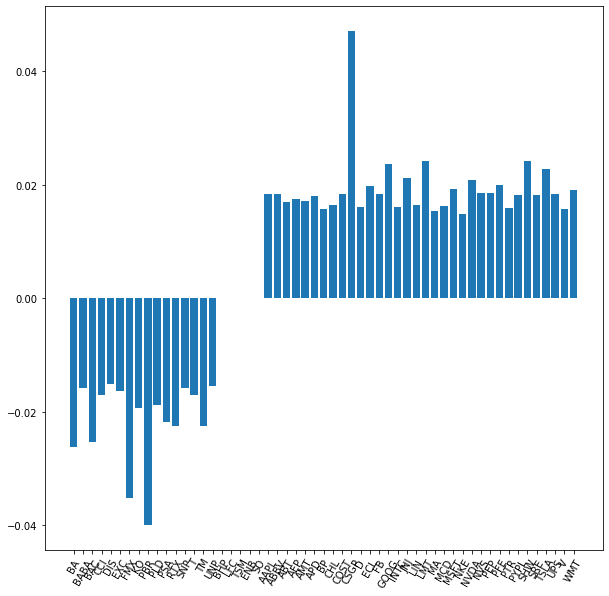

In [109]:
plt.figure(figsize=(10,10))
plt.bar(x = probs.ticker,
        height = probs.weight*probs.direction)
plt.xticks(rotation=60)
plt.show()

In [110]:
probs.prob.sum()

13.976154

In [111]:
probs.weight.sum()

1.0

In [112]:
pd.DataFrame(0, index=data.Ticker.unique(), columns=['prev_close', 'direction']).head(5)

,prev_close,direction
AAPL,0,0
ABBV,0,0
ABT,0,0
AEP,0,0
AMT,0,0


In [113]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'INTC', 'JNJ', 'KO', 'LFC',
       'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA', 'NVS', 'PBR',
       'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX', 'SHW', 'SNP',
       'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS', 'V', 'WMT'],
      dtype=object)

In [114]:
data[data.Ticker=='FMX']

open    high     low   close  spread_open  spread_high  \
20200501 0    65.860  65.860  61.690  62.740        13.28        14.09   
         1    63.050  63.525  63.050  63.230         3.84         3.84   
         2    63.530  63.540  63.050  63.280         2.88         3.84   
         3    63.580  63.580  63.050  63.325         2.78         3.84   
         4    63.585  63.610  63.050  63.610         2.77         3.84   
...              ...     ...     ...     ...          ...          ...   
20200529 385  67.615  67.635  67.550  67.575         0.03         0.13   
         386  67.580  67.590  67.480  67.505         0.04         0.16   
         387  67.480  67.515  67.440  67.500         0.08         0.09   
         388  67.500  67.500  67.460  67.465         0.02         0.08   
         389  67.490  68.235  66.745  66.745         0.08         2.03   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          2.97          4.46           1.0           7.0   
         1          2.89          3.48           7.0           7.0   
         2          2.86          3.38           1.0           7.0   
         3          2.78          3.29           1.0           7.0   
         4          2.72          2.72           1.0           7.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.03           1.0           7.0   
         386        0.01          0.03           1.0           7.0   
         387        0.01          0.02           7.0          13.0   
         388        0.01          0.03           1.0           8.0   
         389        0.02          2.03           1.0           8.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0            7.0           1.0           1.0   
         1            1.0            4.0           1.0           1.0   
         2            1.0            4.0           1.0           1.0   
         3            1.0            4.0           1.0           1.0   
         4            1.0            1.0           1.0           1.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           1.0          11.0   
         386          1.0            1.0           1.0          11.0   
         387          1.0            2.0           1.0          11.0   
         388          1.0            1.0           1.0          10.0   
         389          1.0            8.0          10.0          11.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            1.0    FMX  Consumer Defensive  
         1            1.0            1.0    FMX  Consumer Defensive  
         2            1.0            1.0    FMX  Consumer Defensive  
         3            1.0            1.0    FMX  Consumer Defensive  
         4            1.0            1.0    FMX  Consumer Defensive  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    FMX  Consumer Defensive  
         386          1.0            1.0    FMX  Consumer Defensive  
         387          1.0            1.0    FMX  Consumer Defensive  
         388          1.0            1.0    FMX  Consumer Defensive  
         389          1.0            9.0    FMX  Consumer Defensive  

[7800 rows x 18 columns]

In [115]:
preds

0         1         2         3         4  \
days     timestamps ticker                                                     
20200526 0          AAPL    0.148555  0.178905  0.204498  0.212290  0.255751   
                    ABBV    0.134967  0.175863  0.209909  0.221457  0.257804   
                    ABT     0.157603  0.185945  0.206162  0.212964  0.237326   
                    AEP     0.151542  0.177040  0.208007  0.218877  0.244534   
                    AMT     0.204140  0.185962  0.183822  0.186138  0.239938   
...                              ...       ...       ...       ...       ...   
20200529 387        TSM     0.183894  0.200377  0.202113  0.204207  0.209409   
                    UNP     0.195498  0.204620  0.196899  0.205049  0.197934   
                    UPS     0.189566  0.202912  0.197854  0.205995  0.203673   
                    V       0.198127  0.205358  0.195649  0.203616  0.197250   
                    WMT     0.188625  0.203769  0.196346  0.202301  0.208959   

                            class  confidence  
days     timestamps ticker                     
20200526 0          AAPL        4    0.212290  
                    ABBV        4    0.221457  
                    ABT         4    0.212964  
                    AEP         4    0.218877  
                    AMT         4    0.204140  
...                           ...         ...  
20200529 387        TSM         4    0.204207  
                    UNP         3    0.205049  
                    UPS         3    0.205995  
                    V           1    0.205358  
                    WMT         4    0.203769  

[85690 rows x 7 columns]

In [116]:
### Recreating the price series for each tradable ticker
X_train_temp = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
# X_test_temp = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

actual_series_train = np.array([X_train_temp[X_train_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_train_temp.columns\
                          if 'd_ticker' in i])

cp_x_train = pd.DataFrame(actual_series_train.T,
                         columns=data.Ticker.unique())


In [117]:
## Data: cp_x_train
def returns(price_data,horizon):

#     temp_returns = (price_data.iloc[-horizon:,:].values/price_data.iloc[-(horizon+1):-1,:].values)-1
    
    return (price_data.values[1:]/price_data.values[0:-1])-1
#np.std(temp_returns,axis=0)

In [118]:
cp_x_train

,AAPL,ABBV,ABT,AEP,AMT,APD,BA,BABA,BAC,BHP,...,SO,SRE,T,TM,TSLA,TSM,UNP,UPS,V,WMT
0,289.020,81.760,91.220,82.370,233.540,222.465,142.890,196.920,23.345,38.985,...,55.845,121.405,30.685,121.725,757.875,52.440,156.095,93.445,175.260,121.080
1,288.580,81.285,91.170,82.245,235.130,223.605,141.770,196.710,23.395,38.990,...,55.845,121.050,30.630,121.980,758.915,52.500,156.640,93.420,175.605,121.415
2,289.095,81.445,91.165,81.665,235.150,222.515,143.170,196.515,23.405,39.025,...,55.470,120.280,30.560,122.000,764.475,52.520,156.630,93.265,175.955,121.320
3,290.320,81.540,91.175,81.645,234.545,221.430,142.385,196.720,23.390,39.050,...,55.270,120.205,30.485,121.800,770.750,52.520,156.810,93.290,176.185,121.295
4,290.085,81.495,91.110,81.565,234.840,221.170,142.130,196.590,23.345,39.075,...,55.320,119.760,30.395,121.610,769.650,52.330,156.455,92.865,176.520,121.570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,318.475,91.895,91.225,78.720,241.645,234.135,137.300,199.525,22.635,45.435,...,54.525,123.520,29.885,117.530,817.375,49.785,165.045,96.535,190.300,124.125
6236,318.690,91.970,91.365,78.745,241.790,234.450,137.385,199.310,22.645,45.465,...,54.545,123.620,29.895,117.565,816.835,49.765,165.135,96.585,190.380,124.235
6237,318.850,91.950,91.460,78.745,242.000,234.215,137.540,199.465,22.655,45.455,...,54.550,123.720,29.895,117.560,816.900,49.775,165.005,96.605,190.625,124.285
6238,318.850,92.115,91.435,78.780,242.240,234.270,137.475,199.680,22.655,45.500,...,54.565,123.845,29.875,117.585,816.640,49.805,165.140,96.685,190.710,124.330


In [119]:
art_returns = np.random.normal(0.001,0.0002,(20,10))

In [120]:
np.std(art_returns[-10:],axis=0)

array([0.00016847, 0.00017313, 0.00017343, 0.00013085, 0.0001484 ,
       0.00029412, 0.00018699, 0.0002644 , 0.00024578, 0.00017735])

In [121]:
def online_std(initial_vals,horizon,new_vals,count=0,m2=0):
    
    ## We take a set of initial values, from which we calculate a running mean
    
    if count == 0:
        count = horizon + 1
        
    else:
        count += 1
    print(count)
    
#     updated_vals = initial_vals + (new_vals[0] / count)
    
#     m2 += (new_vals[0] - initial_vals)*(new_vals[0] - updated_vals)
#     print((new_vals[0] - initial_vals))
    updated_vals = initial_vals + ((new_vals[0] - initial_vals) / count)
#     print(updated_vals)
    m2 = initial_vals*(count-1) + (new_vals[0] - initial_vals)*(new_vals[0] - updated_vals)
#     print(m2)
    return updated_vals,m2,count

def online_std_fixed(old_mean,old_vals,new_vals,horizon):
    
    ## We take a set of initial values, from which we calculate a running mean
    
#     if count == 0:
#         count = horizon
        
#     else:
#         count += 1
#     print(count)
    
#     updated_vals = initial_vals + (new_vals[0] / count)
    
#     m2 += (new_vals[0] - initial_vals)*(new_vals[0] - updated_vals)
#     print((new_vals[0] - initial_vals))
    updated_mean = old_mean + ((new_vals - old_vals) / count)
#     print(updated_vals)
    m2 = old_mean*count + (new_vals - old_mean)*(new_vals - updated_mean)
#     print(m2)
    return updated_mean,m2,count

In [122]:
### Illustrate with a horizon of 3.

horizon = 3
# returns_container = np.zeros((horizon,len(data.Ticker.unique())))
returns_container = returns(cp_x_train.iloc[0:horizon+1,0:2],
                            horizon)

output_container = np.zeros((2,#cp_x_train.shape[0]-horizon
                             2))#len(data.Ticker.unique())
# print(output_container.shape)
# print(returns_container)
print(cp_x_train.iloc[0:horizon+1,0:2])


for i,j in enumerate(np.arange(horizon+1,horizon+3)):#cp_x_train.shape[0]#horizon+4
#     print(j)
#     mean,m2,count = online_std_fixed(returns)

    output_container[i] = np.std(returns_container,axis=0)
    
    returns_container[0:-1] = returns_container[1:]
#     print(cp_x_train.iloc[j-1:j+1,:])
    print(cp_x_train.iloc[j-1:j+1,0:2])
    returns_container[-1] = returns(cp_x_train.iloc[j-1:j+1,0:2],1)
    
    

      AAPL    ABBV
0  289.020  81.760
1  288.580  81.285
2  289.095  81.445
3  290.320  81.540
      AAPL    ABBV
3  290.320  81.540
4  290.085  81.495
      AAPL    ABBV
4  290.085  81.495
5  291.110  81.775


In [123]:
cp_x_train.iloc[0:horizon+1,0:2].values[1:]

array([[288.58 ,  81.285],
       [289.095,  81.445],
       [290.32 ,  81.54 ]])

In [124]:
cp_x_train.iloc[0:horizon+1,0:2].values[1:]

array([[288.58 ,  81.285],
       [289.095,  81.445],
       [290.32 ,  81.54 ]])

In [125]:
(cp_x_train.iloc[0:horizon+1,0:2].values[1:]/cp_x_train.iloc[0:horizon+1,0:2].values[0:-1])-1

array([[-0.00152239, -0.00580969],
       [ 0.0017846 ,  0.00196838],
       [ 0.00423736,  0.00116643]])

In [126]:
returns_container

array([[ 0.00423736,  0.00116643],
       [-0.00080945, -0.00055188],
       [ 0.00353345,  0.00343579]])

In [127]:
output_container

array([[0.00236001, 0.00349297],
       [0.00206062, 0.00105132]])

In [128]:
art_returns = np.random.normal(0.001,0.0002,(20,10))
print('initial set of returns:\n',art_returns)

test = np.mean(art_returns[-10:],axis=0)
print('\n\nStandard Deviation of initial set (horizon = 10): ',test)

for i in np.arange(10):
    
    if i == 0:
        mean, m2, count = online_std(test,
                                     10,
                                     np.random.normal(0.0,0.0002,(1,10)))
#         print('\n',i,': ',updated_std)
    else:
        mean, m2, count = online_std(mean,
                                     10,
                                     np.random.normal(0.0,0.0002,(1,10)),
                                     count,
                                     m2)
        
    print(m2/(count-1))
#         print('\n',i,': ',updated_std)

initial set of returns:
 [[0.00106813 0.0007603  0.0011429  0.00104792 0.00105057 0.00114618
  0.00091399 0.00106421 0.00104651 0.00126306]
 [0.00106421 0.00133535 0.00119771 0.00116104 0.00114814 0.00091503
  0.00129002 0.00091854 0.00066856 0.00144965]
 [0.00085558 0.00122925 0.00078758 0.00106011 0.00080056 0.00108503
  0.00075837 0.00082402 0.00109164 0.00119127]
 [0.00078652 0.00118216 0.0011326  0.00128356 0.0009909  0.00122248
  0.00133197 0.0004984  0.00097797 0.00101197]
 [0.00126684 0.00078661 0.00079315 0.00098673 0.00064235 0.0009244
  0.00112609 0.0006277  0.00066414 0.00146892]
 [0.00064419 0.00098705 0.00091517 0.00102793 0.00101475 0.00121305
  0.0007107  0.00101039 0.00098705 0.00133936]
 [0.00148446 0.00109741 0.00122302 0.00100228 0.00081009 0.00130942
  0.00093049 0.00088315 0.0009375  0.00118766]
 [0.00114885 0.00108748 0.00117416 0.00090029 0.00127201 0.00112072
  0.00077739 0.00070434 0.00071198 0.00107412]
 [0.00114174 0.00069047 0.00068878 0.00089557 0.00097653

In [129]:
temp_returns

NameError: name 'temp_returns' is not defined

In [ ]:
temp_returns.std()

In [ ]:
X_train_temp

In [ ]:
actual_series_train

In [ ]:
cp_x_train.iloc[:,0:2]

In [ ]:
actual_series_train.T[10]

In [139]:


### Recreating the price series for each tradable ticker
# X_train_temp = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
X_test_temp = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

# actual_series_train = np.array([X_train_temp[X_train_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_train_temp.columns\
#                           if 'd_ticker' in i])
actual_series_test = np.array([X_test_temp[X_test_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_test_temp.columns\
                          if 'd_ticker' in i])
indexed_series_test = np.divide(actual_series_test,actual_series_test.T[0].reshape(-1,1))*100

cp_x_test = pd.DataFrame(indexed_series_test.T,
                         columns=data.Ticker.unique())

### Restructuring the sector data

temp_sectorIndices = sectorETFS.reset_index()[['level_0','level_1','Ticker']].rename(columns={'level_0':'days',
                                                                                      'level_1':'timestamps',
                                                                                      'Ticker':'ticker'})
# print(temp_sectorIndices)
### Prep to sort
temp_sectorIndices = temp_sectorIndices.sort_values(['days','timestamps','ticker'])

### Sorting the data
temp_sectoretfs = sectorETFS.reset_index().loc[temp_sectorIndices.index,:]

### extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

### Splitting the data
# X_train = [tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
sector_test = temp_sectoretfs[temp_sectorIndices.days>=temp_sectorIndices.days.unique()[first_val_day]].reset_index(drop=True)

### Recreating the price series for each ETF

# X_test_temp = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

actual_series_etfs = np.array([sector_test[sector_test['Ticker']==i].close.reset_index(drop=True).values\
                          for i in sector_test.Ticker.unique()])

indexed_series_etfs = np.divide(actual_series_etfs,actual_series_etfs.T[0].reshape(-1,1))*100

cp_sector_test = pd.DataFrame(indexed_series_etfs.T,
                         columns=sector_test.Ticker.unique())

In [147]:
horizon = 5
# returns_container = np.zeros((horizon,len(data.Ticker.unique())))
print(cp_x_train.iloc[-horizon:,0:2])
returns_container = returns(cp_x_train.iloc[-(horizon+1):,:],
                            horizon)
max_steps = 0
output_container = np.zeros((max_steps+1,#cp_x_train.shape[0]-horizon
                             len(data.Ticker.unique())))#len(data.Ticker.unique())
# print(output_container.shape)
# print(returns_container)
# print(cp_x_train.iloc[0:horizon+1,0:2])

output_container[0] = np.std(returns_container,axis=0)
for i,j in enumerate(np.arange(max_steps)):#cp_x_train.shape[0]#horizon+4
#     print(j)
#     mean,m2,count = online_std_fixed(returns)

    returns_container[0:-1] = returns_container[1:]
    print(i)
    if i == 0:
        
        
#         print(actual_series_train.T[-1,:])
#         print(actual_series_test.T[i,:])
        returns_container[-1] = (actual_series_test.T[i]/actual_series_train.T[-1])-1#returns(cp_x_test.iloc[i:i+2,0:2],1)
    
    else:
        
        returns_container[-1] = (actual_series_test.T[i]/actual_series_test.T[i-1])-1
#     print(cp_x_train.iloc[j-1:j+1,:])
#     print(cp_x_train.iloc[j-1:j+1,0:2])
#     returns_container[-1] = returns(cp_x_test.iloc[i:i+2,0:2],1)
    
    output_container[i+1] = np.std(returns_container,axis=0)

         AAPL    ABBV
6235  318.475  91.895
6236  318.690  91.970
6237  318.850  91.950
6238  318.850  92.115
6239  323.875  93.295


In [148]:
returns_container

array([[ 4.24074888e-04,  2.17687075e-04,  4.38668641e-04,
        -1.27016385e-04,  5.17555482e-04, -1.49464065e-04,
        -6.18699276e-04, -2.00435948e-04,  8.84368782e-04,
         4.40383133e-04,  0.00000000e+00, -5.12968484e-04,
         0.00000000e+00, -1.32165868e-04,  5.68543619e-04,
         3.11138768e-04,  4.24322145e-05,  2.49438763e-04,
         3.18015583e-04, -8.14442785e-04, -1.06435064e-04,
        -2.28241023e-04, -1.13358201e-04,  1.60939889e-04,
        -3.12239800e-04, -1.11098767e-04,  0.00000000e+00,
         2.62494750e-04,  1.07269913e-03, -5.44014144e-04,
        -5.43020825e-05, -5.45926027e-05,  1.60419229e-04,
        -1.80100302e-04, -5.89970501e-05,  0.00000000e+00,
        -1.15017444e-04,  0.00000000e+00, -5.13845275e-04,
         4.56253355e-04,  2.55677545e-03,  8.64218049e-04,
        -3.33388898e-04,  8.68213824e-05,  0.00000000e+00,
        -2.22044605e-16, -2.42816673e-04,  0.00000000e+00,
        -2.20731811e-03,  4.34505887e-04,  1.81104739e-0

In [149]:
output_container

array([[0.0061478 , 0.00490954, 0.00670907, 0.00433341, 0.00971035,
        0.00901257, 0.02089398, 0.01323529, 0.01854085, 0.00892062,
        0.00700657, 0.0098094 , 0.00680428, 0.0040821 , 0.00694907,
        0.00807749, 0.01219456, 0.00665403, 0.00852328, 0.01086751,
        0.00778317, 0.00975421, 0.0074823 , 0.00873979, 0.00362046,
        0.01482515, 0.01312773, 0.00616892, 0.00696369, 0.01129351,
        0.01326527, 0.00470139, 0.01056876, 0.00512706, 0.00192613,
        0.03629718, 0.00396492, 0.00321367, 0.01228867, 0.01026649,
        0.00720704, 0.00692413, 0.01695582, 0.00375761, 0.01022172,
        0.00777159, 0.00797732, 0.01148577, 0.019399  , 0.00677673,
        0.01180774, 0.01037908, 0.00503078, 0.01028445, 0.00257569]])

In [ ]:
returns_container.shape

In [ ]:
output_container.shape

In [ ]:
(actual_series_test.T[1]/actual_series_test.T[0])-1

In [ ]:
output_container

In [ ]:
data

In [ ]:
np.concatenate([[[i,j] for i in np.unique(X_train.index.get_level_values(1))] \
                                                  for j in np.unique(X_train.index.get_level_values(0))])

In [ ]:
np.concatenate([[[i,j] for i in np.unique(X_test.index.get_level_values(1))] \
                for j in np.unique(X_test.index.get_level_values(0))])

In [ ]:
data.loc[(20200522,389)]

In [ ]:
data.loc[(20200526,0)]

In [ ]:
### Recreating the price series for each tradable ticker
X_train_temp = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
# X_test_temp = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

actual_series_train = np.array([X_train_temp[X_train_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_train_temp.columns\
                          if 'd_ticker' in i])

cp_x_train = pd.DataFrame(actual_series_train.T,
                         columns=data.Ticker.unique())

In [ ]:
cp_x_train.iloc[-1,:].T

In [ ]:
X_train.loc[(20200522,389)]

In [ ]:
X_test.loc[(20200526,0)]

In [ ]:
data.loc[(20200526,0)]

In [ ]:
X.loc[tempIndices[(tempIndices.days==20200526)&(tempIndices.timestamps==0)].index]

In [157]:
'''
1) Each timestep
    -check for new positions
    -re-evaluate current positions
    -rebalance maybe
    -

2) Max_positions: Check if the specified number of max positions results in an uneven split? like max position = 9.
'''


class backtest():
    def __init__(self, 
                 X_test,
#                  X_train,
                 data, 
                 preds, 
                 weight_scheme,
                 rebal_scheme,
                 rebal_init_data,
                 rebal_last_known_price,
                 rebal_lookback_horizon, 
                 rebal_risk_aversion,
                 max_steps, 
                 max_positions, 
                 n_classes,
                 verbose=False):

        self.all_tickers = data.Ticker.unique()
        self.open_long_positions = []#'AAPL','ABT','LFC'
        self.open_short_positions = []#'BAC','KO','ENB'

        self.ticker_dict = {}   # key: ticker, value: [open_price, direction, pnl]
        self.hist_rets = np.ones((max_steps,len(self.all_tickers)+1))
        self.pnl = []
        self.prev_close = pd.DataFrame(0, index=self.all_tickers, columns=['prev_close', 'direction'])
        self.t = 0

        self.X_test = X_test
        self.data = data
        self.preds = preds
        ## New
        self.weight_scheme = weight_scheme
        self.rebal_scheme = rebal_scheme
        self.rebal_init_data = rebal_init_data
        self.rebal_last_known_price = rebal_last_known_price
        self.rebal_lookback_horizon = rebal_lookback_horizon
        self.rebal_risk_aversion = rebal_risk_aversion
        self.max_steps = max_steps
        self.max_positions = max_positions
        self.n_classes = n_classes
        self.verbose = verbose

        if self.verbose >= 1:
            print(f'initial self.open_long_positions: {self.open_long_positions}')
            print(f'initial self.open_short_positions: {self.open_short_positions} \n')

    def run(self):

        unique_timesteps = np.concatenate([[[i,j] for i in np.unique(self.X_test.index.get_level_values(1))] \
                                                  for j in np.unique(self.X_test.index.get_level_values(0))])
        print(self.all_tickers,'\n')
        
        if self.rebal_scheme == 'slpg': # slpg: Stop Loss / Profit Goal
            
            self.returns_container = returns(self.rebal_init_data,#cp_x_train.iloc[-(self.rebal_lookback_horizon+1):,:]
                                        self.rebal_lookback_horizon)
            
#             self.output_container = np.zeros((self.max_steps+1,
#                                          len(self.all_tickers)))
            self.output_container = np.zeros((self.max_steps,
                                         len(self.all_tickers)))

#             self.output_container[0] = np.std(self.returns_container,axis=0)
        print('Size of returns container: ', self.returns_container.shape)
        while self.t < self.max_steps:

            ts = unique_timesteps[self.t]
            print(ts)
            print('\n\n################ Period %i ################\n\n' % self.t)
            #print(i)
            try:
                ts_data = self.data.sort_index().loc[(ts[1], ts[0])] ## sort_index() to prevent the performance warning.
            except:
                pass
            if ts_data.shape == 0:
                pass

            close_info = ts_data[['close','spread_close','Ticker']].reset_index(drop=True)
            ts_preds = self.preds.loc[(ts[1], ts[0])]
            print(close_info)
            self.update_positions(ts, close_info, ts_preds)#,self.rebal_scheme

            self.t += 1

        print(f'run function finished at step {self.t}, time: {ts}')

    def update_positions(self, ts, close_info, ts_preds):#,rebal_scheme
        
#         close_short = []
#         close_buy = []
        
        # use predictions to select what to hold, order by the confidence
#         print(ts_preds[ts_preds['class'] == (self.n_classes - 1)].sort_values('confidence',
#                                                                               ascending=False))

        # Long positions
        long_pos = ts_preds[ts_preds['class'] == (self.n_classes - 1)].sort_values('confidence',
                                                                                   ascending=False)
        # Short positions
        short_pos = ts_preds[ts_preds['class'] == 0].sort_values('confidence',ascending=False)
        
        # Open all available long positions if the number of available long positions are less than the
        # intended number of long positions.
#         print(long_pos,'\n')
#         print(short_pos,'\n')
#         if self.t == 0:
        
        if (long_pos.shape[0] <= (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

            long_list = long_pos.index.values
            short_list = short_pos.index.values

            if self.verbose:
                print("\n NOTE: The number of available positions are %i, compared to the intended %i.\n" % (len(long_list)+\
                                                                                                            len(short_list),self.max_positions))
        ## If both the available long and short exceeds the needed:
        elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] > (self.max_positions / 2)):

            long_list = long_pos.iloc[0:int(self.max_positions/2),:].index.values
            short_list = short_pos.iloc[0:int(self.max_positions/2),:].index.values

        ## If there are less long and excess short positions:
        elif (long_pos.shape[0] <= (self.max_positions / 2)) & (short_pos.shape[0] > (self.max_positions / 2)):

            long_list = long_pos.index.values
            short_list = short_pos.iloc[0:int(self.max_positions-long_pos.shape[0]),:].index.values

        ## If there are less short and excess long positions:
        elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

            long_list = long_pos.iloc[0:int(self.max_positions-short_pos.shape[0]),:].index.values
            short_list = short_pos.index.values

        ## Else return eror
        else:
#             print('Longs: \n\n',long_pos,'\n')
#             print('Shorts: \n\n',short_pos,'\n')
#             long_list = long_pos.iloc[0:int(self.max_positions/2),:].index.values
            raise ValueError('Something is wrong - please investigate!')
#         else:
#             long_list = long_pos.index.values
#             short_list = short_pos.index.values
#         long_list = ts_preds[ts_preds['class'] == (self.n_classes - 1)].index.values
#         short_list = ts_preds[ts_preds['class'] == 0].index.values

        if self.verbose >= 1:
            print(f'long_list: {long_list}')
            print(f'short_list: {short_list} \n')

        # check if any new positions are made
        new_long = long_list[~np.isin(long_list, self.open_long_positions)]
        new_short = short_list[~np.isin(short_list, self.open_short_positions)]
        
        ###### check if any needs closed before we determine if any new ones should be 
        ###### disregarded.
#         print(close_long,close_short)
#         close_long = close_long + list(np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)])
#         close_short = close_short + list(np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)])
        
        ## Closing those that have changed signal.
        close_long = list(np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)])
        close_short = list(np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)])
        
        ## Check if time to close positions due to stop loss or profit goal.
        if (self.t > 0) & (self.rebal_scheme == 'slpg'):
            
            print('\n\n',self.hist_rets[self.t-1])
            print('Risk Aversion: ', self.rebal_risk_aversion[0],self.rebal_risk_aversion[1])
            print(self.output_container[self.t-1],'\n\n')
        
        if self.verbose >= 1:
            print(f'close_long: {close_long}')
            print(f'close_short: {close_short} \n')

        self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_long]
        self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

        if self.verbose >= 1:
            print('Closing trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')
        
        long_candidates = self.open_long_positions+list(new_long)
        short_candidates = self.open_short_positions+list(new_short)
#         print(long_candidates)
#         print(ts_preds[ts_preds.index.isin(long_candidates)].sort_values('confidence',ascending=False))
        
#         print('New shorts:\n\n',new_short,'\n')
#         print('Short candidates:\n\n',short_candidates,'\n')
#         print('Long candidates:\n\n',long_candidates,'\n')
        if (len(long_candidates) <= (self.max_positions / 2)) & (len(short_candidates) <= (self.max_positions / 2)):
#             print('\nProcessed in 0\n')
            # Do nothing, sticking with the generated list, consisting of open positions and new buys!
            pass

            if self.verbose:
                print("\n NOTE: The number of available positions are %i, compared to the intended %i.\n" % (len(long_candidates)+\
                                                                                                            len(short_candidates),
                                                                                                             self.max_positions))
#             close_long = []
#             close_short = []
        ## If both the available long and short exceeds the needed:
        elif (len(long_candidates) > (self.max_positions / 2)) & (len(short_candidates) > (self.max_positions / 2)):
#             print('\nProcessed in 1\n')
#             long_list = long_pos.iloc[0:int(self.max_positions/2),:].index.values
#             short_list = short_pos.iloc[0:int(self.max_positions/2),:].index.values
            ### Prepping the candidates
            temp_long = ts_preds[ts_preds.index.isin(long_candidates)].sort_values('confidence',ascending=False).index.values
            temp_short = ts_preds[ts_preds.index.isin(short_candidates)].sort_values('confidence',ascending=False).index.values
#             print(np.arange(len(temp_long))[np.isin(temp_long,new_long)])
#             print('Temp short:\n\n',ts_preds[ts_preds.index.isin(short_candidates)].sort_values('confidence',ascending=False),'\n')
            ## Determining the ranking of the new candidates
            new_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,new_long)]
            new_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,new_short)]
#             print('new_short_ranking:\n\n',new_short_ranking,'\n')
            # if some new buy candidates have a ranking that is outside the neeeded long positions,
            # we diregard that new buy.
            if max(new_long_ranking) > ((self.max_positions / 2) - 1):
                new_long = [j for i,j in enumerate(new_long) if new_long_ranking[i] <= ((self.max_positions / 2) - 1)]

            ## Same for sell candidates
            if max(new_short_ranking) > ((self.max_positions / 2) - 1):
                new_short = [j for i,j in enumerate(new_short) if new_short_ranking[i] <= ((self.max_positions / 2) - 1)]
            
#             print('new short:\n\n',new_short,'\n')
            
            # Locating the close candidates (those that have ranking exceeding the maximum number of intended
            # long positions)
#             print(temp_long)
#             close_candidates_long = list(temp_long[int(self.max_positions / 2):])
#             close_candidates_short = list(temp_short[int(self.max_positions / 2):])

            # Only close those that are not in new buy (in position to be bought)
#             close_long = [i for i in close_candidates_long if i not in new_long]
#             close_short = [i for i in close_candidates_short if i not in new_short]
#             print(np.where(new_buy in temp_long,new_buy,temp_long))


        ## If there are less long and excess short positions:
        elif (len(long_candidates) <= (self.max_positions / 2)) & (len(short_candidates) > (self.max_positions / 2)):
#             print('\nProcessed in 2\n')
#             long_list = long_pos.index.values

            ## With less long candidates than needed, there is no need to do anything at this point, as all existing
            ## positions should be kept, unless they do not have a buy signal anymore but then they are dropped below,
            ## and new ones should be added.
#             close_long = [] # Because of above, the only action we take for buys is initialising the close_buy list.

            ## For the sell candidates we first identify if we need to adjust. If we do not need to adjust, we just
            ## proceed as normally.
#             short_list = short_pos.iloc[0:int(self.max_positions-long_pos.shape[0]),:].index.values
            if len(short_candidates) >= (self.max_positions - len(long_candidates)):

                temp_short = ts_preds[ts_preds.index.isin(short_candidates)].sort_values('confidence',ascending=False).index.values
#                 print(np.arange(len(temp_long))[np.isin(temp_long,new_buy)])

                ## Determining the ranking of the new candidates
                new_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,new_short)]

                # if some new sell candidates have a ranking that is outside the neeeded short positions,
                # we diregard that new sell.
                if max(new_short_ranking) > ((self.max_positions / 2) - 1):
                    new_short = [j for i,j in enumerate(new_short) if new_short_ranking[i] <= ((self.max_positions / 2) - 1)]

                # Locating the close candidates (those that have ranking exceeding the maximum number of intended
                # short positions)
#                 close_candidates_short = list(temp_short[(self.max_positions / 2):])

                # Only close those that are not in new buy (in position to be bought)
#                 close_short = [i for i in close_candidates_short if i not in new_short]

        ## If there are less short and excess long positions:
        elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):
#             print('\nProcessed in 3\n')
#             long_list = long_pos.iloc[0:int(self.max_positions-short_pos.shape[0]),:].index.values
#             short_list = short_pos.index.values
            ### Vice versa, compared to the if statement just above.

            ## With less sell candidates than needed, there is no need to do anything at this point, as all existing
            ## positions should be kept, unless they do not have a sell signal anymore but then they are dropped below,
            ## and new ones should be added.
#             close_short = [] # Because of above, the only action we take for buys is initialising the close_buy list.

            ## For the short candidates we first identify if we need to adjust. If we do not need to adjust, we just
            ## proceed as normally.
#             short_list = short_pos.iloc[0:int(self.max_positions-long_pos.shape[0]),:].index.values
            if len(long_candidates) >= (self.max_positions - len(short_candidates)):

                temp_long = ts_preds[ts_preds.index.isin(long_candidates)].sort_values('confidence',ascending=False).index.values
#                 print(np.arange(len(temp_long))[np.isin(temp_long,new_buy)])

                ## Determining the ranking of the new candidates
                new_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,new_long)]

                # if some new sell candidates have a ranking that is outside the neeeded short positions,
                # we diregard that new sell.
                if max(new_long_ranking) > ((self.max_positions / 2) - 1):
                    new_long = [j for i,j in enumerate(new_long) if new_long_ranking[i] <= ((self.max_positions / 2) - 1)]

                # Locating the close candidates (those that have ranking exceeding the maximum number of intended
                # short positions)
#                 close_candidates_long = list(temp_long[(self.max_positions / 2):])

                # Only close those that are not in new buy (in position to be bought)
#                 close_long = [i for i in close_candidates_long if i not in new_long]

        ## Else return eror
        else:
#             print('\nProcessed in 4\n')
#             print('Longs:\n\n',long_pos,'\n')
#             print('Shorts:\n\n',short_pos,'\n')
#             long_list = long_pos.iloc[0:int(self.max_positions/2),:].index.values
            raise ValueError('Something is wrong - please investigate!')

        if self.verbose >= 1:
            print(f'new_long: {new_long}')
            print(f'new_short: {new_short} \n')

        self.open_long_positions += [long_i for long_i in new_long]
        self.open_short_positions += [short_i for short_i in new_short]

        self.ticker_dict

        if self.verbose >= 1:
            print('Opening new trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

#         # check if any are closed
# #         print(close_long,close_short)
#         close_long = close_long + list(np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)])
#         close_short = close_short + list(np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)])

#         if self.verbose >= 1:
#             print(f'close_long: {close_long}')
#             print(f'close_short: {close_short} \n')

#         self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_long]
#         self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

#         if self.verbose >= 1:
#             print('Closing trades, status after:')
#             print(f'all long: {self.open_long_positions}')
#             print(f'all short: {self.open_short_positions} \n')

        if self.t > 0:

            # update directions for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction'] = -1
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction'] = 1

            current_ret = (close_info.close.values / self.prev_close.prev_close.values) - 1
            current_ret = (current_ret * self.prev_close.direction.values) + 1

            ## Correcting those we close
            boolcousin = np.isin(self.all_tickers, close_short) | np.isin(self.all_tickers, close_long)

            current_ret[boolcousin] = (close_info[boolcousin].close.values\
                                                                 *abs(self.prev_close[boolcousin].direction.values)\
                                                                 +(close_info[boolcousin].spread_close.values / 2)\
                                                                 *self.prev_close[boolcousin].direction.values)\
                                                                /self.prev_close[boolcousin].prev_close.values

            ## Fixing those not in use, which by the 'direction' equals a return of zero.
            current_ret[self.prev_close.direction.values == 0] = 1

            # update individual returns for open positions
            self.hist_rets[self.t, :-1] = current_ret * self.hist_rets[self.t - 1, :-1]

            # update total portfolio returns for open positions
            self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]

            # update directions for new positions
            self.prev_close.loc[np.isin(self.all_tickers, new_long), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_short), 'direction']  = -1
            
            ## Place to update returns in the returns container
            self.returns_container[0:-1] = self.returns_container[1:]
#             print('Return:\n\n',(close_info.close.values/self.prev_close.prev_close)-1)
            self.returns_container[-1] = (close_info.close.values/self.prev_close.prev_close)-1
            # Updating the standard deviation of the returns
            self.output_container[self.t] = np.std(self.returns_container,axis=0)
            
            # Updating the last seen price
            self.prev_close.loc[:,'prev_close'] = close_info.close.values

            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_long),'prev_close'] = close_info[np.isin(self.all_tickers, new_long)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_long)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_short),'prev_close'] = close_info[np.isin(self.all_tickers, new_short)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_short)].spread_close.values / 2)

            # ************ check: can a ticker be in both closed positions and new positions? then directions change x2

            # set directions == 0 for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction']  = 0
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0

        else:

            # update directions (first entry)
            self.prev_close.loc[np.isin(self.all_tickers, new_long), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_short), 'direction']  = -1
            
            if self.rebal_scheme == 'slpg':
                
                ## Place to update returns in the returns container
                # Roll back the returns one period
                self.returns_container[0:-1] = self.returns_container[1:]
            
                # Include the new return
                #returns_container[-1] = (actual_series_test.T[i]/actual_series_train.T[-1])-1
                print('New prices:\n\n',close_info.close.values)
                print('Old prices:\n\n',self.rebal_last_known_price)
                print('Return:\n\n',(close_info.close.values/self.rebal_last_known_price)-1)
                self.returns_container[-1] = (close_info.close.values/self.rebal_last_known_price)-1
                # Updating the standard deviation of the returns
                self.output_container[self.t] = np.std(self.returns_container,axis=0)
                
            self.prev_close.loc[:,'prev_close'] = close_info.close.values

            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_long),'prev_close'] = close_info[np.isin(self.all_tickers, new_long)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_long)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_short),'prev_close'] = close_info[np.isin(self.all_tickers, new_short)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_short)].spread_close.values / 2)


######### A little initialization ###########
max_steps = 5
rebal_lookback_horizon = 10
rebal_init_data = cp_x_train.iloc[-(rebal_lookback_horizon+1):,:]
print(rebal_init_data)
rebal_last_known_price = cp_x_train.iloc[-1,:].T
backtest_obj = backtest(X_test=X_test,
                        data=data,
                        preds=preds,
                        weight_scheme = None,
                        rebal_scheme = 'slpg',
                        rebal_init_data = rebal_init_data,
                        rebal_last_known_price = rebal_last_known_price,
                        rebal_lookback_horizon = rebal_lookback_horizon,
                        rebal_risk_aversion = (2,4),
                        max_steps=max_steps,
                        max_positions = 10,
                        n_classes=5,
                        verbose=True)
backtest_obj.run()


         AAPL    ABBV     ABT     AEP      AMT      APD       BA     BABA  \
6229  317.925  91.945  91.240  78.725  241.530  234.535  137.530  199.150   
6230  317.920  91.995  91.230  78.745  241.285  234.405  137.365  199.290   
6231  318.050  92.035  91.230  78.755  241.320  234.405  137.465  199.580   
6232  318.065  92.025  91.220  78.725  241.340  234.520  137.365  199.585   
6233  318.335  92.010  91.235  78.740  241.790  234.445  137.405  199.685   
6234  318.340  91.875  91.185  78.730  241.520  234.170  137.385  199.565   
6235  318.475  91.895  91.225  78.720  241.645  234.135  137.300  199.525   
6236  318.690  91.970  91.365  78.745  241.790  234.450  137.385  199.310   
6237  318.850  91.950  91.460  78.745  242.000  234.215  137.540  199.465   
6238  318.850  92.115  91.435  78.780  242.240  234.270  137.475  199.680   
6239  323.875  93.295  93.025  79.645  248.300  239.555  144.675  206.305   

         BAC     BHP  ...      SO      SRE       T       TM     TSLA     TS

C:\Users\PC\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


       close  spread_close Ticker
0    323.180          0.04   AAPL
1     93.050          0.06   ABBV
2     92.855          0.03    ABT
3     79.620          0.08    AEP
4    247.855          0.99    AMT
5    239.455          4.35    APD
6    145.090          0.18     BA
7    205.910          0.10   BABA
8     23.825          0.01    BAC
9     46.590          0.02    BHP
10    23.375          0.01     BP
11   160.420          0.34    CCI
12    35.455          0.21    CHL
13   305.360          0.20   COST
14   668.230          7.54   CSGP
15    82.020          0.04      D
16   121.485          0.09    DIS
17   203.310          0.36    ECL
18    32.155          0.09    ENB
19    37.910          0.06    EXC
20   238.835          0.09     FB
21    68.650          0.52    FMX
22  1433.760          3.52   GOOG
23    63.500          0.02   INTC
24   145.235          0.37    JNJ
25    46.790          0.02     KO
26     9.370          0.06    LFC
27   193.940          0.06    LIN
28   373.585  

       close  spread_close Ticker
0    322.690          0.08   AAPL
1     92.940          0.08   ABBV
2     92.160          0.14    ABT
3     79.560          0.10    AEP
4    245.480          0.30    AMT
5    239.385          0.55    APD
6    145.140          0.18     BA
7    206.050          0.06   BABA
8     23.815          0.01    BAC
9     46.525          0.01    BHP
10    23.285          0.01     BP
11   159.240          0.32    CCI
12    35.430          0.08    CHL
13   305.400          0.26   COST
14   668.210          6.42   CSGP
15    82.050          0.08      D
16   120.625          0.09    DIS
17   203.515          0.45    ECL
18    31.900          0.02    ENB
19    37.880          0.02    EXC
20   239.710          0.06     FB
21    67.740          1.02    FMX
22  1434.085          2.27   GOOG
23    63.705          0.01   INTC
24   145.340          0.06    JNJ
25    46.590          0.02     KO
26     9.380          0.02    LFC
27   194.095          0.13    LIN
28   374.285  

In [ ]:
# test_preds = preds.copy(deep=True)
# test_preds.loc[:,'class'] = 0

In [ ]:
backtest_obj.hist_rets

In [ ]:
stop

In [151]:
pot_returns = backtest_obj.hist_rets

### Storing returns in PD
pot_returns_pd = pd.DataFrame(pot_returns,columns = np.concatenate([data.Ticker.unique(),['Portfolio']]))

In [ ]:
pot_returns_pd

In [ ]:
cp_x_test

In [ ]:
# {j:pot_returns_pd.iloc[-1,i] for i,j in enumerate(pot_returns_pd.columns)}

In [ ]:
# pnl_color = []

# for i,j in enumerate(pot_returns_pd.columns):
    
#     total_return = pot_returns_pd.iloc[-1,i]
    
#     if total_return < 1:
        
#         print(j,': Red - ',total_return)
#         pnl_color.append('red')
#     elif total_return == 1:
        
#         print(j,': Gray - ',total_return)
#         pnl_color.append('gray')
#     elif total_return > 1:
#         print(j,': Green - ',total_return)
#         pnl_color.append('green')

In [153]:
ticker_dict = {j:i for i,j in enumerate(pot_returns_pd.columns)}
ticker_dict

{'AAPL': 0,
 'ABBV': 1,
 'ABT': 2,
 'AEP': 3,
 'AMT': 4,
 'APD': 5,
 'BA': 6,
 'BABA': 7,
 'BAC': 8,
 'BHP': 9,
 'BP': 10,
 'CCI': 11,
 'CHL': 12,
 'COST': 13,
 'CSGP': 14,
 'D': 15,
 'DIS': 16,
 'ECL': 17,
 'ENB': 18,
 'EXC': 19,
 'FB': 20,
 'FMX': 21,
 'GOOG': 22,
 'INTC': 23,
 'JNJ': 24,
 'KO': 25,
 'LFC': 26,
 'LIN': 27,
 'LMT': 28,
 'MA': 29,
 'MCD': 30,
 'MSFT': 31,
 'NKE': 32,
 'NVDA': 33,
 'NVS': 34,
 'PBR': 35,
 'PEP': 36,
 'PFE': 37,
 'PLD': 38,
 'PSA': 39,
 'PTR': 40,
 'PYPL': 41,
 'RTX': 42,
 'SHW': 43,
 'SNP': 44,
 'SO': 45,
 'SRE': 46,
 'T': 47,
 'TM': 48,
 'TSLA': 49,
 'TSM': 50,
 'UNP': 51,
 'UPS': 52,
 'V': 53,
 'WMT': 54,
 'Portfolio': 55}

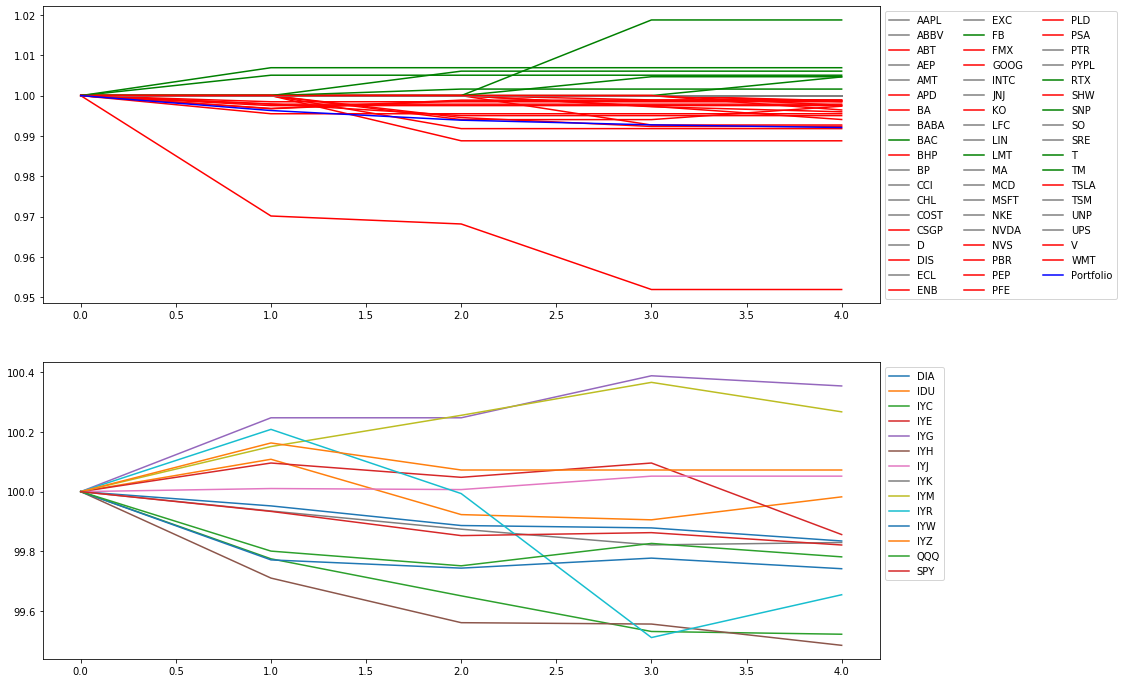

In [156]:
pnl_color = [('r' if pot_returns_pd.iloc[-1,i]<1 else 
             ('gray' if pot_returns_pd.iloc[-1,i]==1 else 
             'g')) for i in np.arange(pot_returns_pd.shape[1]-1)]
pnl_color += ['blue']

## True if plotting against ETFS of sectors and markets, else against tickers.
plot_against_market = True

### Tickers to investigate
## Either a list of tickers or None
tickers_to_plot = None#None['NVDA','BA']

### Setting up the subplot
fig,ax = plt.subplots(2,1,figsize=(15,12))

### Plotting the obtained returns
if tickers_to_plot is not None:
    ticker_location = [ticker_dict[i] for i in tickers_to_plot]
    pot_returns_pd.iloc[:,ticker_location].plot(color=np.array(pnl_color)[ticker_location],ax=ax[0])#.reshape(-1,50)#c=np.array(pnl_color[0:3])
else:
    pot_returns_pd.iloc[:,].plot(color=pnl_color,ax=ax[0])
ax[0].legend(ncol=3,
             bbox_to_anchor=[1,1])

### Plotting the actual price development

# Against the market
if plot_against_market:
    cp_sector_test.iloc[0:pot_returns_pd.shape[0],].plot(ax=ax[1])
else:
    if tickers_to_plot is not None:
        
        ticker_location = [ticker_dict[i] for i in tickers_to_plot]
        cp_x_test.iloc[0:pot_returns_pd.shape[0],ticker_location].plot(color='black',
                                                   ax=ax[1],legend=None)
    else:
        cp_x_test.iloc[0:pot_returns_pd.shape[0],].plot(color='black',
                                                   ax=ax[1],legend=None)
ax[1].legend(bbox_to_anchor=[1,1])

plt.show()

In [ ]:
sectorETFS.reset_index()

In [ ]:
tempIndices

In [ ]:
### Restructuring the sector data

temp_sectorIndices = sectorETFS.reset_index()[['level_0','level_1','Ticker']].rename(columns={'level_0':'days',
                                                                                      'level_1':'timestamps',
                                                                                      'Ticker':'ticker'})
# print(temp_sectorIndices)
### Prep to sort
temp_sectorIndices = temp_sectorIndices.sort_values(['days','timestamps','ticker'])

### Sorting the data
temp_sectoretfs = sectorETFS.reset_index().loc[temp_sectorIndices.index,:]

### extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

### Splitting the data
# X_train = [tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
sector_test = temp_sectoretfs[temp_sectorIndices.days>=temp_sectorIndices.days.unique()[first_val_day]].reset_index(drop=True)

sector_test

In [ ]:
price_candles

In [ ]:
indices

In [ ]:
temp_sectorIndices

In [ ]:
# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

In [ ]:
cp_x_test

In [ ]:
pot_returns_pd

In [ ]:
'''
            OLD VERSION
            
1) Each timestep
    -check for new positions
    -re-evaluate current positions
    -rebalance maybe
    -

'''


class backtest():
    def __init__(self, X_test, data, preds, weight_scheme, max_steps, max_positions, n_classes,verbose=False):

        self.all_tickers = data.Ticker.unique()
        self.open_long_positions = []#'AAPL','ABT','LFC'
        self.open_short_positions = []#'BAC','KO','ENB'
        self.ticker_dict = {}   # key: ticker, value: [open_price, direction, pnl]
        self.hist_rets = np.ones((max_steps,len(self.all_tickers)+1))
        self.pnl = []
        self.prev_close = pd.DataFrame(0, index=self.all_tickers, columns=['prev_close', 'direction'])
        self.t = 0

        self.X_test = X_test
        self.data = data
        self.preds = preds
        ## New
        self.weight_scheme = weight_scheme
        self.max_steps = max_steps
        self.max_positions = max_positions
        self.n_classes = n_classes
        self.verbose = verbose

        if self.verbose >= 1:
            print(f'initial self.open_long_positions: {self.open_long_positions}')
            print(f'initial self.open_short_positions: {self.open_short_positions} \n')



    def run(self):

        unique_timesteps = np.concatenate([[[i,j] for i in np.unique(self.X_test.index.get_level_values(1))] \
                                                  for j in np.unique(self.X_test.index.get_level_values(0))])
        print(self.all_tickers,'\n')

        while self.t < self.max_steps:

            ts = unique_timesteps[self.t]
            print('\n\n################ Period %i ################\n\n' % self.t)
            #print(i)
            try:
                ts_data = self.data.sort_index().loc[(ts[1], ts[0])] ## sort_index() to prevent the performance warning.
            except:
                pass
            if ts_data.shape == 0:
                pass

            #print(ts_data)

            close_info = ts_data[['close','spread_close','Ticker']].reset_index(drop=True)
            ts_preds = self.preds.loc[(ts[1], ts[0])]

            self.update_positions(ts, close_info, ts_preds)

            self.t += 1

        print(f'run function finished at step {self.t}, time: {ts}')

        #for ts in unique_timesteps[:2]:

        # for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
        #     #print(i)
        #     ts_data = data.loc[(ts[0], ts[1])]
        #     if ts_data.shape == 0:
        #         pass
        #         #print(i, 'hovhov')


    def update_positions(self, ts, close_info, ts_preds):

        #print(ts_preds, '\n')

        # use predictions to select what to hold
        long_list = ts_preds[ts_preds['class'] == (self.n_classes - 1)].index.values
        short_list = ts_preds[ts_preds['class'] == 0].index.values

        if self.verbose >= 1:
            print(f'long_list: {long_list}')
            print(f'short_list: {short_list} \n')

        # if any open positions
        # if (len(self.open_long_positions) > 0) or (len(self.open_short_positions) > 0):


        # check if any new positions are made
        new_buy = long_list[~np.isin(long_list, self.open_long_positions)]
        new_sell = short_list[~np.isin(short_list, self.open_short_positions)]




#         print(self.ticker_dict)
#             self.hist_rets

        if self.verbose >= 1:
            print(f'new_buy: {new_buy}')
            print(f'new_sell: {new_sell} \n')

        self.open_long_positions += [long_i for long_i in new_buy]
        self.open_short_positions += [short_i for short_i in new_sell]

        self.ticker_dict

        if self.verbose >= 1:
            print('Opening new trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

#             print(self.open_long_positions,'\n') #[~np.isin(self.open_long_positions, long_list)])
#             print(np.isin(self.open_long_positions, long_list),'\n')
#             print(long_list,'\n')

        # check if any are closed
        close_buy = np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)]
        close_short = np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)]

        if self.verbose >= 1:
            print(f'close_buy: {close_buy}')
            print(f'close_short: {close_short} \n')

        self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_buy]
        self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

        if self.verbose >= 1:
            print('Closing trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

        if self.t > 0:

            # update directions for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction'] = -1
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction'] = 1

#             print(close_info.close.values[21])
#             print(close_info.spread_close.values[21])
#             print(self.prev_close.direction.values[21])
#             print('Close prices: \n\n',close_info.close.values)
            # * self.prev_close.direction.values\
            current_ret = (close_info.close.values / self.prev_close.prev_close.values) - 1
            current_ret = (current_ret * self.prev_close.direction.values) + 1
#             print(self.all_tickers,'\n')
#             print(current_ret,'\n')
            ## Correcting those we close
            boolcousin = np.isin(self.all_tickers, close_short) | np.isin(self.all_tickers, close_buy)
#             print(self.all_tickers[boolcousin],'\n')
#             print(close_info[boolcousin].close.values,'\n')
#             print(close_info[boolcousin].spread_close.values,'\n')
#             print(self.prev_close[boolcousin].direction.values,'\n')
#             print((close_info[boolcousin].close.values\
#                                                                  *abs(self.prev_close[boolcousin].direction.values)\
#                                                                  +(close_info[boolcousin].spread_close.values / 2)\
#                                                                  *self.prev_close[boolcousin].direction.values))
            current_ret[boolcousin] = (close_info[boolcousin].close.values\
                                                                 *abs(self.prev_close[boolcousin].direction.values)\
                                                                 +(close_info[boolcousin].spread_close.values / 2)\
                                                                 *self.prev_close[boolcousin].direction.values)\
                                                                /self.prev_close[boolcousin].prev_close.values
#             print(current_ret)
#             print(self.prev_close.direction.values)
            ## Fixing those not in use, which by the 'direction' equals a return of zero.
#             current_ret[current_ret == 0] = 1
            current_ret[self.prev_close.direction.values == 0] = 1

            # update individual returns for open positions
            self.hist_rets[self.t, :-1] = current_ret * self.hist_rets[self.t - 1, :-1]

            # update total portfolio returns for open positions
#             print(current_ret)
#             print((current_ret-1)[current_ret!=0])
#             current_ret[self.prev_close.direction.values == 0] = 0

            ## if the weights should be based on the probabilities and their distribution.
#             if self.weight_scheme == 'prob_dist':

#             ## if the weights should be based on the probabilities and equally distributed between long and short positions.
#             elif self.weight_scheme == 'prob_equal':

#             else:

            self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]
            
            
        
            # update directions for new positions
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1
            
#             print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
            
#             print('Spread:\n\n',close_info.spread_close)
#             print('Corrected Prices:\n\n',self.prev_close)
            # ************ check: can a ticker be in both closed positions and new positions? then directions change x2

            # set directions == 0 for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction']  = 0
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0

        else:



            # update directions (first entry)
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1


#             self.ticker_dict = {j:[close_info.iloc[i,0], 1, 0] if j in new_buy \
#                                 else j:[close_info.iloc[i,0], -1, 0] if j in new_sell \
#                                 else j:[close_info.iloc[i,0], 0, 0] \
#                                     for i,j in enumerate(close_info.Ticker)}

#             self.ticker_dict = {j.Ticker:[j.close, 1, 0] if j in new_buy \
#                                 else j.Ticker:[j.close, -1, 0] if j in new_sell \
#                                 else j.Ticker:[j.close, 0, 0] \
#                                     for i,j in enumerate(close_info.iterrows())}

#             print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
#             print(self.prev_close)

#         print(close_info.close.copy(deep=True).values)

#         self.prev_close.loc[:,'prev_close'] = close_info.close.values

#         print(close_info.close.copy(deep=True).values)

        #print(self.prev_close.loc[:,'prev_close'])


backtest_obj = backtest(X_test=X_test,
                        data=data,
                        preds=preds,
                        weight_scheme = None,
                        max_steps=50,
                        max_positions = 10,
                        n_classes=5)
backtest_obj.run()


In [ ]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:]

In [ ]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:].astype(str).to_csv('tabledata.csv')

In [ ]:
data.sort_index().loc[(20200526,0)].reset_index().loc[21]

In [ ]:
data.sort_index().loc[(20200526,1)].reset_index().loc[21]

In [ ]:
data[data.Ticker=='AAPL']

In [ ]:
[i for i in backtest_obj.hist_rets[1]]

In [ ]:
backtest_obj.prev_close

In [ ]:
data.sort_index()

In [ ]:
print("Keras version:", keras.__version__)

In [ ]:
preds

In [ ]:
data

In [ ]:
ts_preds = preds.loc[(20200526, 0)]
ts_preds[ts_preds['class'] == 1].index.values

In [ ]:
long_list = ts_preds[ts_preds['class'] == 1].index.values
short_list = ts_preds[ts_preds['class'] == 0].index.values

print(long_list, short_list,'\n\n')

open_long_positions = ['AAPL','ABT']
open_short_positions = ['BAC','KO']

# check if any new positions are made
# if any open positions
if (len(open_long_positions) > 0) or (len(open_short_positions) > 0):
    new_buy = long_list[~np.isin(long_list, open_long_positions)]
    new_short = short_list[~np.isin(short_list, open_short_positions)] 
    
new_buy, new_short

In [ ]:
open_long_positions[int(~np.isin(open_long_positions, long_list))]

In [ ]:
~np.isin(open_long_positions, long_list)

In [ ]:
# check if any are closed
close_buy = open_long_positions[~np.isin(open_long_positions, long_list)] 
close_short = open_short_positions[~np.isin(open_short_positions, short_list)] 

In [ ]:
np.isin(long_list, open_long_positions, invert=True)

In [ ]:
for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
    #print(i)
    ts_data = data.loc[(ts[0], ts[1])]
    if ts_data.shape == 0:
        pass

In [ ]:
ts_data[['close','spread_close']]

In [ ]:
#tmp = [(i,j) for i,j in zip(X_test.index.get_level_values(0),X_test.index.get_level_values(1))]

X_test.reset_index().groupby(['days','timestamps']).size()


#np.unique(X_test.index.get_level_values(1))

In [ ]:
# 20200526  0
X_test

In [ ]:
np.unique(X_test.index.get_level_values(1))

In [ ]:
hej = np.concatenate([[[i,j] for i in np.unique(X_test.index.get_level_values(1))] \
                              for j in np.unique(X_test.index.get_level_values(0))])
hej

In [ ]:
def t1():
    for i in hej[:]:
        #print(i)
        try:
            timestep_data = X_test.loc[(i[1], i[0])]
        except:
            pass
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [ ]:
def t2():
    for i in X_test.reset_index().groupby(['days','timestamps']).size().index[:]:
        #print(i)
        timestep_data = X_test.loc[(i[0], i[1])]
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [ ]:
%timeit t1()
%timeit t2()

In [ ]:
X_test

In [ ]:
np.unique(( X_test.index.get_level_values(0).values, X_test.index.get_level_values(1).values ))